In [14]:
import pybaseball
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
# Block 1: Setup and Fetch Pitcher Data

import pybaseball
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import math
import matplotlib.pyplot as plt # Added here for use in later blocks
import seaborn as sns          # Added here for use in later blocks

# Set plot style (optional)
# sns.set_theme(style="whitegrid")


def get_pitcher_data_interactive():
    """
    Prompts user for PITCHER name & dates, looks up ID, fetches Statcast data.
    Returns the fetched data DataFrame, pitcher's first name, last name,
    start date string, and end date string.
    Returns (None, None, None, None, None) if lookup or fetch fails.
    """
    # --- Get User Input ---
    first_name = input("Enter the PITCHER's first name: ").strip()
    last_name = input("Enter the PITCHER's last name: ").strip()

    while True:
        start_date_str = input("Enter the start date (YYYY-MM-DD): ").strip()
        try:
            datetime.strptime(start_date_str, '%Y-%m-%d')
            break
        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD.")

    while True:
        end_date_str = input("Enter the end date (YYYY-MM-DD): ").strip()
        try:
            datetime.strptime(end_date_str, '%Y-%m-%d')
            if end_date_str < start_date_str:
                print("End date cannot be before the start date.")
            else:
                break
        except ValueError:
            print("Invalid date format. Please use YYYY-MM-DD.")

    # --- Initialize variables before lookup ---
    player_id = None
    actual_first = None
    actual_last = None
    player_info = pd.DataFrame()

    # --- Look Up Player ID ---
    print(f"\nLooking up player ID for {first_name} {last_name}...")
    try:
        # playerid_lookup works for both pitchers and batters
        player_info = pybaseball.playerid_lookup(last_name, first_name, fuzzy=False)
        if player_info.empty:
            print("No exact match found, trying fuzzy search...")
            player_info = pybaseball.playerid_lookup(last_name, first_name, fuzzy=True)
            if player_info.empty:
                 print(f"Error: Could not find any player ID for {first_name} {last_name} after fuzzy search.")
                 # Let the check below handle the return

        # --- Handle Player Selection (only if player_info is not empty) ---
        if not player_info.empty:
            if len(player_info) == 1:
                player_id = int(player_info['key_mlbam'].iloc[0])
                actual_first = player_info['name_first'].iloc[0]
                actual_last = player_info['name_last'].iloc[0]
                print(f"Found Player: {actual_first} {actual_last} (ID: {player_id})")
            else:
                print(f"\nFound multiple players matching '{first_name} {last_name}'. Please choose one:")
                display_cols = ['name_first', 'name_last', 'key_mlbam', 'mlb_played_first', 'mlb_played_last']
                print(player_info[display_cols].to_markdown(index=False))
                valid_ids = player_info['key_mlbam'].tolist()
                while True:
                    try:
                        chosen_id_str = input(f"Enter the 'key_mlbam' for the player you want: ").strip()
                        chosen_id = int(chosen_id_str)
                        if chosen_id in valid_ids:
                            player_id = chosen_id
                            selected_player = player_info[player_info['key_mlbam'] == player_id].iloc[0]
                            actual_first = selected_player['name_first']
                            actual_last = selected_player['name_last']
                            print(f"Selected Player: {actual_first} {actual_last} (ID: {player_id})")
                            break
                        else:
                            print("Invalid ID. Please enter one of the 'key_mlbam' values listed above.")
                    except ValueError:
                        print("Invalid input. Please enter the numeric 'key_mlbam'.")
    except Exception as e:
        print(f"An error occurred during player lookup: {e}")

    # --- Check if Player ID was determined ---
    if player_id is None or actual_first is None or actual_last is None:
         print("Could not determine player ID after lookup attempts.")
         return None, None, None, None, None # Return None if player not found

    # --- Fetch Statcast Data for PITCHER --- ## *** KEY CHANGE HERE *** ##
    print(f"\nFetching PITCHER Statcast data for {actual_first} {actual_last} ({player_id}) from {start_date_str} to {end_date_str}...")
    try:
        # Use statcast_pitcher instead of statcast_batter
        player_data = pybaseball.statcast_pitcher(start_dt=start_date_str, end_dt=end_date_str, player_id=player_id) # MODIFIED

        if player_data.empty:
            print("No Statcast data found for this pitcher and date range.")
            # Return success, but with empty data; include dates
            return player_data, actual_first, actual_last, start_date_str, end_date_str
        else:
            print(f"Successfully fetched {len(player_data)} pitches.")
            # Return fetched data, names, and dates
            return player_data, actual_first, actual_last, start_date_str, end_date_str

    except Exception as e:
        print(f"An error occurred while fetching Statcast data: {e}")
         # Return None for all expected values on fetch error
        return None, None, None, None, None

# --- Call the function and store results (using pitcher-specific names) ---
print("=== Pitcher Data Fetcher ===")
pitcher_statcast_data, pitcher_first_name, pitcher_last_name, start_date, end_date = get_pitcher_data_interactive()

# Optional check after Block 1 runs
if pitcher_statcast_data is None:
    print("\nBlock 1: Failed to retrieve data. Subsequent blocks cannot run.")
elif pitcher_statcast_data.empty:
    print("\nBlock 1: Retrieved empty dataset (no pitches found for criteria). Subsequent blocks might not show results.")
else:
     # Use pitcher-specific variable names in messages
     print(f"\nBlock 1: Data retrieval successful for pitcher {pitcher_first_name} {pitcher_last_name} ({start_date} to {end_date}).")
     print(f"DataFrame shape: {pitcher_statcast_data.shape}")
     print("Variables `pitcher_statcast_data`, `pitcher_first_name`, etc. are ready for subsequent blocks.")

=== Pitcher Data Fetcher ===


Enter the PITCHER's first name:  emmanuel
Enter the PITCHER's last name:  clase
Enter the start date (YYYY-MM-DD):  2024-01-01
Enter the end date (YYYY-MM-DD):  2025-04-20



Looking up player ID for emmanuel clase...
Found Player: emmanuel clase (ID: 661403)

Fetching PITCHER Statcast data for emmanuel clase (661403) from 2024-01-01 to 2025-04-20...
Gathering Player Data
Successfully fetched 1480 pitches.

Block 1: Data retrieval successful for pitcher emmanuel clase (2024-01-01 to 2025-04-20).
DataFrame shape: (1480, 113)
Variables `pitcher_statcast_data`, `pitcher_first_name`, etc. are ready for subsequent blocks.



--- Block 2: Analyzing Pitch Arsenal ---
Analyzing 1403 pitches for arsenal overview...
Found 'release_spin_rate' data.

Pitch Arsenal Summary for emmanuel clase (2024-01-01 to 2025-04-20)
| pitch_type   |   Usage (%) |   Count |   Avg Speed (mph) |   Avg Spin (rpm) |   Avg Horz Break (in) |   Avg Vert Break (in) |
|:-------------|------------:|--------:|------------------:|-----------------:|----------------------:|----------------------:|
| FC           |        76.8 |  1078.0 |              99.3 |           2579.7 |                   3.4 |                  11.8 |
| SL           |        21.3 |   299.0 |              90.7 |           2549.8 |                   7.2 |                   2.2 |
| SI           |         1.5 |    21.0 |              99.8 |           2498.7 |                  -7.5 |                  13.5 |
| FF           |         0.4 |     5.0 |              98.8 |           2474.2 |                  -5.0 |                  14.2 |

--- Pitch Movement Plot ---


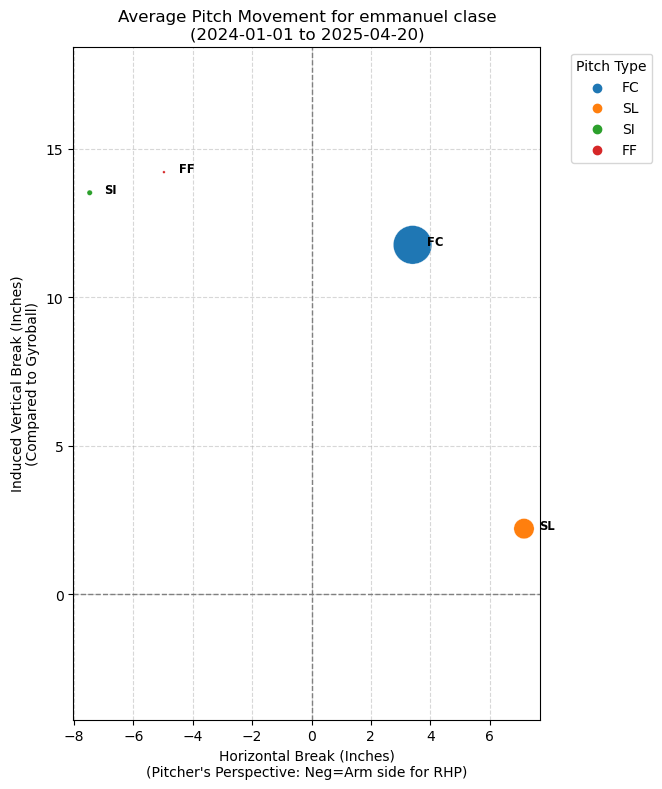

--- End of Block 2 ---


In [16]:
# Block 2: Pitch Arsenal Overview (Corrected to_markdown call)

print("\n--- Block 2: Analyzing Pitch Arsenal ---")

# Check if data was loaded successfully in Block 1
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name:

    # --- Define Required Columns ---
    required_cols = ['pitch_type', 'release_speed', 'pfx_x', 'pfx_z']
    spin_rate_col = 'release_spin_rate'
    has_spin_data = spin_rate_col in pitcher_statcast_data.columns

    if 'pitch_type' not in pitcher_statcast_data.columns:
        print("Error: 'pitch_type' column is required but missing.")
    else:
        # --- Data Preparation ---
        arsenal_data = pitcher_statcast_data[pitcher_statcast_data['pitch_type'].notna()].copy()

        if not arsenal_data.empty:
            print(f"Analyzing {len(arsenal_data)} pitches for arsenal overview...")

            # --- Calculations ---
            total_pitches = len(arsenal_data)
            usage = arsenal_data['pitch_type'].value_counts()
            usage_pct = (usage / total_pitches) * 100

            agg_dict = {
                'Avg Speed (mph)': ('release_speed', 'mean'),
                'Avg Horz Break (in)': ('pfx_x', lambda x: x.mean() * 12), # Convert feet to inches
                'Avg Vert Break (in)': ('pfx_z', lambda x: x.mean() * 12), # Convert feet to inches
                'Count': ('pitch_type', 'count')
            }
            if has_spin_data and arsenal_data[spin_rate_col].notna().any(): # Check if spin col actually has data
                agg_dict['Avg Spin (rpm)'] = (spin_rate_col, 'mean')
                print(f"Found '{spin_rate_col}' data.")
            else:
                print(f"Note: '{spin_rate_col}' column not found or empty, skipping spin rate calculation.")
                has_spin_data = False # Ensure we don't try to display it later

            try:
                 # Handle potential missing numeric columns during agg if checks failed somehow
                 pitch_summary = arsenal_data.groupby('pitch_type', observed=True).agg(
                     **{k:v for k,v in agg_dict.items() if v[0] in arsenal_data.columns} # Only agg if col exists
                 )
            except Exception as e: # Catch other potential agg errors
                 print(f"Error during aggregation: {e}. Cannot generate summary table.")
                 pitch_summary = pd.DataFrame()

            if not pitch_summary.empty:
                # Add Usage Percentage and sort
                pitch_summary['Usage (%)'] = usage_pct
                pitch_summary.sort_values(by='Usage (%)', ascending=False, inplace=True)

                # --- Display Summary Table ---
                title = f"Pitch Arsenal Summary for {pitcher_first_name} {pitcher_last_name} ({start_date} to {end_date})"
                print("\n" + "="*len(title))
                print(title)
                print("="*len(title))

                # Reorder columns for display
                display_cols = ['Usage (%)', 'Count', 'Avg Speed (mph)']
                if has_spin_data and 'Avg Spin (rpm)' in pitch_summary.columns:
                    display_cols.append('Avg Spin (rpm)')
                display_cols.extend(['Avg Horz Break (in)', 'Avg Vert Break (in)'])

                # Ensure display_cols only contains columns that actually exist in pitch_summary
                display_cols = [col for col in display_cols if col in pitch_summary.columns]

                if display_cols: # Only print if there are columns to show
                    # *** MODIFIED HERE: Removed formatters argument ***
                    print(pitch_summary[display_cols].to_markdown(floatfmt=".1f"))
                    # Note: % sign for Usage and +/- for break won't appear in markdown
                else:
                    print("No summary columns available to display.")


                # --- Visualize Movement ---
                # Check if movement columns exist before plotting
                if 'Avg Horz Break (in)' in pitch_summary.columns and 'Avg Vert Break (in)' in pitch_summary.columns:
                    print("\n--- Pitch Movement Plot ---")
                    plt.figure(figsize=(8, 8))
                    sns.scatterplot(
                        data=pitch_summary,
                        x='Avg Horz Break (in)',
                        y='Avg Vert Break (in)',
                        hue=pitch_summary.index,
                        s=pitch_summary['Usage (%)'] * 10,
                        legend='full'
                    )

                    # Add labels to points
                    for i in range(pitch_summary.shape[0]):
                        plt.text(pitch_summary['Avg Horz Break (in)'].iloc[i]+0.5,
                                 pitch_summary['Avg Vert Break (in)'].iloc[i],
                                 pitch_summary.index[i],
                                 horizontalalignment='left', size='small', color='black', weight='semibold')

                    plt.axhline(0, color='grey', linestyle='--', lw=1)
                    plt.axvline(0, color='grey', linestyle='--', lw=1)
                    plt.title(f"Average Pitch Movement for {pitcher_first_name} {pitcher_last_name}\n({start_date} to {end_date})")
                    plt.xlabel("Horizontal Break (Inches)\n(Pitcher's Perspective: Neg=Arm side for RHP)")
                    plt.ylabel("Induced Vertical Break (Inches)\n(Compared to Gyroball)")
                    plt.grid(True, linestyle='--', alpha=0.5)
                    plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.axis('equal')
                    plt.tight_layout(rect=[0, 0, 0.85, 1])
                    plt.show()
                else:
                    print("\nSkipping movement plot because movement data columns are missing.")

            else:
                 print("Could not generate pitch summary table (aggregation failed or produced empty result).")

        else:
            print("No valid pitch data found to analyze arsenal after initial filtering.")

elif pitcher_statcast_data is None:
    print("Skipping arsenal analysis because pitcher data was not loaded successfully in Block 1.")
else:
     print("Skipping arsenal analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 2 ---")


--- Block 3: Analyzing Pitch Location and CSW% ---

Part 1: Overall Pitch Location Density
Generating location density plot based on 1403 pitches...


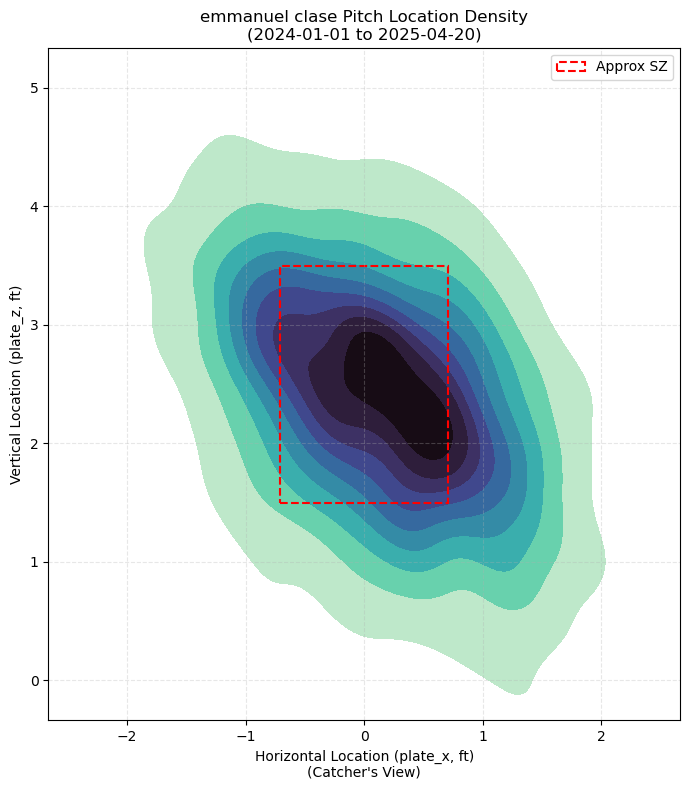


Part 2: Called Strike + Whiff % (CSW%) Heatmap
Calculating CSW% based on 1403 pitches...


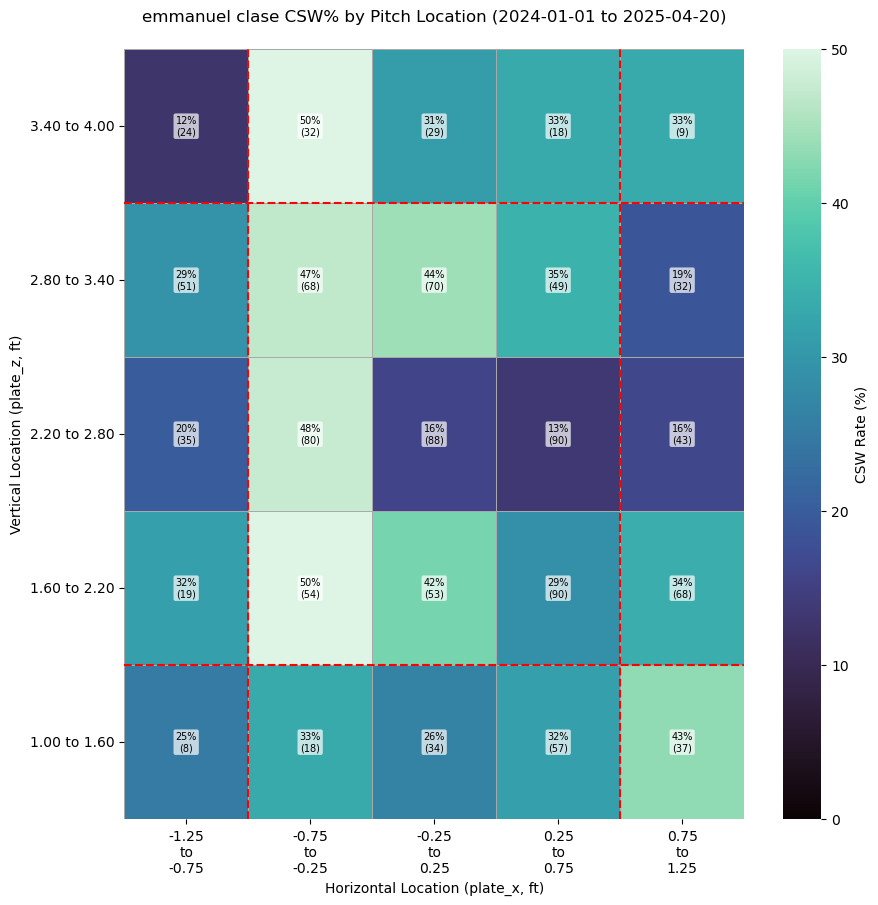

--- End of Block 3 ---


In [31]:
# Block 3: Pitch Location Analysis (Final Version with Text Background)

print("\n--- Block 3: Analyzing Pitch Location and CSW% ---")

# Check prerequisite data and variables from Block 1
# Ensure variables like pitcher_statcast_data, pitcher_first_name, start_date, end_date exist
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # Make sure necessary libraries are imported (likely done in Block 1)
    try: pd; np; plt; sns
    except NameError:
        print("Importing necessary libraries for Block 3...")
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns
        print("Libraries imported.")

    # --- Define Required Columns ---
    required_cols_loc = ['plate_x', 'plate_z']
    required_cols_csw = ['plate_x', 'plate_z', 'description']

    # --- Part 1: Overall Pitch Location Density Plot ---
    print("\nPart 1: Overall Pitch Location Density")
    if all(col in pitcher_statcast_data.columns for col in required_cols_loc):
        loc_data = pitcher_statcast_data[
            pitcher_statcast_data['plate_x'].notna() &
            pitcher_statcast_data['plate_z'].notna()
        ].copy()

        if not loc_data.empty:
            print(f"Generating location density plot based on {len(loc_data)} pitches...")
            plt.figure(figsize=(7, 8))
            ax_loc = plt.gca()

            sns.kdeplot(
                data=loc_data,
                x='plate_x',
                y='plate_z',
                fill=True,
                cmap='mako_r',
                thresh=0.05,
                ax=ax_loc
            )

            # Add approximate strike zone overlay
            sz_x_min, sz_x_max = -17/24, 17/24 # Plate width (17in) / 2, converted to feet
            sz_z_min, sz_z_max = 1.5, 3.5     # Approximate vertical zone
            sz_rect = plt.Rectangle((sz_x_min, sz_z_min), (sz_x_max - sz_x_min), (sz_z_max - sz_z_min),
                                    edgecolor='red', linestyle='--', fill=False, linewidth=1.5, label='Approx SZ')
            ax_loc.add_patch(sz_rect)

            plt.axis('equal')
            plt.xlim(-2.5, 2.5)
            plt.ylim(0, 5.0)
            plt.title(f"{pitcher_first_name} {pitcher_last_name} Pitch Location Density\n({start_date} to {end_date})")
            plt.xlabel("Horizontal Location (plate_x, ft)\n(Catcher's View)")
            plt.ylabel("Vertical Location (plate_z, ft)")
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.legend(handles=[sz_rect])
            plt.tight_layout()
            plt.show()

        else:
            print("No pitches with valid location data found to plot density.")
    else:
        missing = [col for col in required_cols_loc if col not in pitcher_statcast_data.columns]
        print(f"Skipping location density plot because required columns are missing: {', '.join(missing)}")


    # --- Part 2: CSW% Heatmap ---
    print("\nPart 2: Called Strike + Whiff % (CSW%) Heatmap")
    if all(col in pitcher_statcast_data.columns for col in required_cols_csw):
        pitch_data_csw = pitcher_statcast_data[
            pitcher_statcast_data['description'].notna() &
            pitcher_statcast_data['plate_x'].notna() &
            pitcher_statcast_data['plate_z'].notna()
        ].copy()

        whiff_descriptions = {'swinging_strike', 'missed_bunt'}
        pitch_data_csw['is_csw'] = (pitch_data_csw['description'] == 'called_strike') | \
                                   (pitch_data_csw['description'].isin(whiff_descriptions))

        if not pitch_data_csw.empty:
            print(f"Calculating CSW% based on {len(pitch_data_csw)} pitches...")
            x_bins = np.linspace(-1.25, 1.25, 6)
            z_bins = np.linspace(1.0, 4.0, 6)
            pitch_data_csw['x_zone_bin'] = pd.cut(pitch_data_csw['plate_x'], bins=x_bins)
            pitch_data_csw['z_zone_bin'] = pd.cut(pitch_data_csw['plate_z'], bins=z_bins)
            pitch_data_csw.dropna(subset=['x_zone_bin', 'z_zone_bin'], inplace=True)

            if not pitch_data_csw.empty:
                zone_csw_stats = pitch_data_csw.groupby(['z_zone_bin', 'x_zone_bin'], observed=False).agg(
                    CSW_Count=('is_csw', 'sum'), TotalPitches=('is_csw', 'count')
                ).reset_index()
                zone_csw_stats['CSW_Rate'] = (zone_csw_stats['CSW_Count'] / zone_csw_stats['TotalPitches']) * 100

                csw_heatmap_data = None; annot_labels_csw = None
                total_pivot_csw = None
                try:
                    csw_heatmap_data = zone_csw_stats.pivot_table(
                        index='z_zone_bin', columns='x_zone_bin', values='CSW_Rate', observed=False
                    )
                    total_pivot_csw = zone_csw_stats.pivot_table(
                        index='z_zone_bin', columns='x_zone_bin', values='TotalPitches', observed=False, fill_value=0
                    )

                    # Create multi-line annotation labels (Rate%\n(Count))
                    annot_labels_csw = pd.DataFrame(index=csw_heatmap_data.index, columns=csw_heatmap_data.columns, dtype=str)
                    for row_idx in csw_heatmap_data.index:
                        for col_idx in csw_heatmap_data.columns:
                            rate = csw_heatmap_data.loc[row_idx, col_idx]
                            total = total_pivot_csw.loc[row_idx, col_idx]
                            if total > 0 and pd.notna(rate):
                                annot_labels_csw.loc[row_idx, col_idx] = f"{rate:.0f}%\n({total:.0f})"
                            else:
                                annot_labels_csw.loc[row_idx, col_idx] = f"-\n({total:.0f})"

                except Exception as e:
                    print(f"Error creating pivot table or annotations for CSW% heatmap: {e}")
                    csw_heatmap_data = None; annot_labels_csw = None

                # Visualization (Manual Annotations with Background)
                if csw_heatmap_data is not None and not csw_heatmap_data.empty and annot_labels_csw is not None:
                    plt.figure(figsize=(10, 10))
                    ax_csw = plt.gca()
                    sns.heatmap(
                        csw_heatmap_data,
                        annot=False, # Add annotations manually
                        fmt="",
                        cmap="mako", # Colormap (can adjust: "Blues", "rocket_r", etc.)
                        linewidths=.5, linecolor='darkgrey',
                        cbar_kws={'label': 'CSW Rate (%)'},
                        ax=ax_csw, vmin=0
                    )

                    # --- Manually Add Text Annotations with Background ---
                    bbox_props = dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, ec='none') # Define background box style

                    for i in range(csw_heatmap_data.shape[0]): # Loop through rows (0 to 4)
                        for j in range(csw_heatmap_data.shape[1]): # Loop through columns (0 to 4)
                            label = annot_labels_csw.iloc[i, j] # Get multi-line label
                            # Use black text color, relying on bbox for contrast
                            ax_csw.text(j + 0.5, i + 0.5, label,
                                        ha='center', va='center', color='black', fontsize=7,
                                        bbox=bbox_props) # Add the background box
                    # ----------------------------------------------------

                    # Add Strike Zone lines
                    ax_csw.axvline(1, color='red', linestyle='--', lw=1.5); ax_csw.axvline(4, color='red', linestyle='--', lw=1.5)
                    ax_csw.axhline(1, color='red', linestyle='--', lw=1.5); ax_csw.axhline(4, color='red', linestyle='--', lw=1.5)

                    # Set Ticks and Labels
                    x_tick_labels = [f"{b.left:.2f}\nto\n{b.right:.2f}" for b in csw_heatmap_data.columns]
                    z_tick_labels = [f"{b.left:.2f} to {b.right:.2f}" for b in csw_heatmap_data.index]
                    plt.xticks(ticks=np.arange(len(csw_heatmap_data.columns)) + 0.5, labels=x_tick_labels, rotation=0)
                    plt.yticks(ticks=np.arange(len(csw_heatmap_data.index)) + 0.5, labels=z_tick_labels, rotation=0)
                    ax_csw.invert_yaxis() # Put low zones at the bottom

                    plt.xlabel("Horizontal Location (plate_x, ft)")
                    plt.ylabel("Vertical Location (plate_z, ft)")
                    plot_title = f"{pitcher_first_name} {pitcher_last_name} CSW% by Pitch Location ({start_date} to {end_date})"
                    plt.title(plot_title, pad=20)
                    plt.show()
                else:
                     print("No CSW% data available to plot heatmap after binning and pivoting.")
            else:
                 print("No pitches found within the defined 5x5 grid boundaries for CSW% map.")
        else:
            print("No valid pitch data found to calculate CSW%.")
    else:
        missing = [col for col in required_cols_csw if col not in pitcher_statcast_data.columns]
        print(f"Skipping CSW% analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping location analysis because pitcher data was not loaded successfully in Block 1.")
else:
     print("Skipping location analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 3 ---")


--- Block 4: Analyzing Pitcher Plate Discipline Induced ---
Calculating discipline metrics based on 1403 pitches...

Opponent Plate Discipline Summary vs emmanuel clase (2024-01-01 to 2025-04-20)
Pitches Analyzed           1403
Opponent Swing %          57.3%
Opp. Zone Swing %         74.4%
Opp. Chase % (O-Swing)    37.0%
Opp. Contact %            75.1%
Opp. Zone Contact %       82.5%
Opp. Outside Contact %    57.4%
Whiff % (per swing)       24.9%
CSW % (per pitch)         28.7%

--- Whiff% per Swing by Pitch Type ---


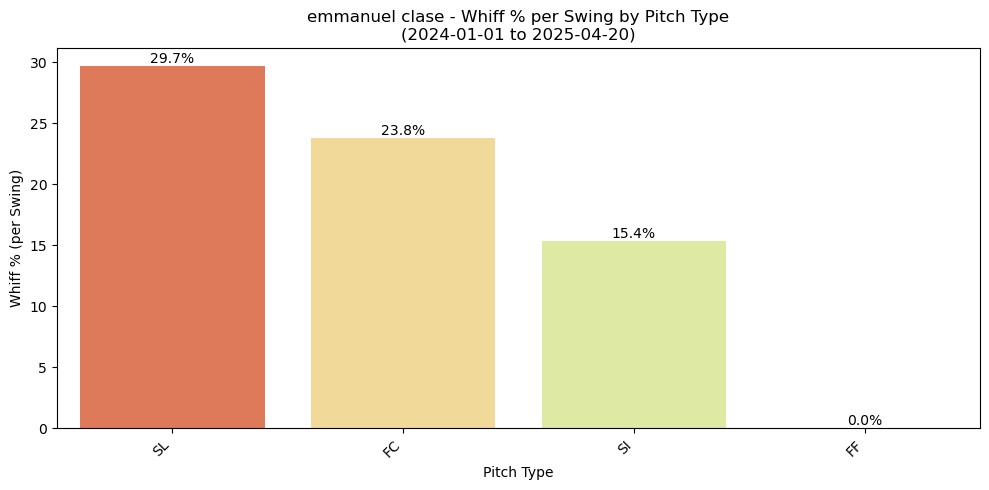


--- Rolling 100-Pitch CSW% ---


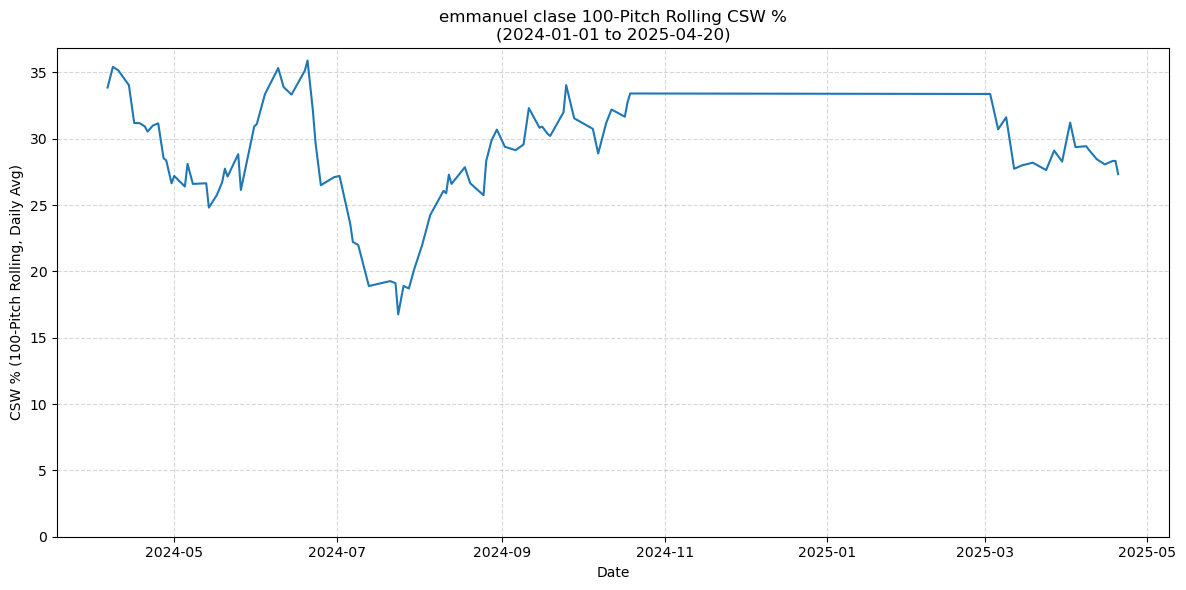

--- End of Block 4 ---


In [18]:
# Block 4: Inducing Swings & Misses (Pitcher Plate Discipline)

print("\n--- Block 4: Analyzing Pitcher Plate Discipline Induced ---")

# Check prerequisite data and variables from Block 1
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Required Columns ---
    required_cols = ['description', 'zone', 'game_date', 'pitch_type'] # Need pitch_type for breakdown

    # Check if all required columns exist
    if all(col in pitcher_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        # 1. Filter for pitches with valid description and zone
        pitch_data_pd = pitcher_statcast_data[
            pitcher_statcast_data['description'].notna() &
            pitcher_statcast_data['zone'].notna() &
            pitcher_statcast_data['game_date'].notna() & # Needed for rolling plot
            pitcher_statcast_data['pitch_type'].notna()  # Needed for breakdown plot
        ].copy()

        # 2. Define event descriptions
        swing_descriptions = {
            'hit_into_play', 'foul', 'swinging_strike', 'foul_tip',
            'foul_bunt', 'missed_bunt', 'hit_into_play_no_out', 'hit_into_play_score'
        }
        whiff_descriptions = {'swinging_strike', 'missed_bunt'}

        if not pitch_data_pd.empty:
            # 3. Create boolean columns
            pitch_data_pd['is_swing'] = pitch_data_pd['description'].isin(swing_descriptions)
            pitch_data_pd['is_whiff'] = pitch_data_pd['description'].isin(whiff_descriptions)
            pitch_data_pd['is_contact'] = pitch_data_pd['is_swing'] & (~pitch_data_pd['is_whiff'])
            pitch_data_pd['is_in_zone'] = (pitch_data_pd['zone'] >= 1) & (pitch_data_pd['zone'] <= 9)
            pitch_data_pd['is_out_of_zone'] = pitch_data_pd['zone'] >= 11
            pitch_data_pd['is_csw'] = (pitch_data_pd['description'] == 'called_strike') | pitch_data_pd['is_whiff']

            print(f"Calculating discipline metrics based on {len(pitch_data_pd)} pitches...")

            # --- Calculate Aggregate Counts & Rates for Table ---
            total_pitches = len(pitch_data_pd)
            total_swings = pitch_data_pd['is_swing'].sum()
            total_contact = pitch_data_pd['is_contact'].sum()
            total_whiffs = pitch_data_pd['is_whiff'].sum()
            total_csw = pitch_data_pd['is_csw'].sum()

            pitches_in_zone = pitch_data_pd['is_in_zone'].sum()
            swings_in_zone = pitch_data_pd.loc[pitch_data_pd['is_in_zone'], 'is_swing'].sum()
            contact_in_zone = pitch_data_pd.loc[pitch_data_pd['is_in_zone'], 'is_contact'].sum()

            pitches_out_zone = pitch_data_pd['is_out_of_zone'].sum()
            swings_out_zone = pitch_data_pd.loc[pitch_data_pd['is_out_of_zone'], 'is_swing'].sum()
            contact_out_zone = pitch_data_pd.loc[pitch_data_pd['is_out_of_zone'], 'is_contact'].sum()

            # Calculate Rates (Handle Division by Zero)
            opp_swing_rate = (total_swings / total_pitches * 100) if total_pitches > 0 else np.nan
            opp_contact_rate = (total_contact / total_swings * 100) if total_swings > 0 else np.nan
            opp_whiff_rate = (total_whiffs / total_swings * 100) if total_swings > 0 else np.nan # SwStr% per swing

            opp_zone_swing_rate = (swings_in_zone / pitches_in_zone * 100) if pitches_in_zone > 0 else np.nan
            opp_zone_contact_rate = (contact_in_zone / swings_in_zone * 100) if swings_in_zone > 0 else np.nan

            opp_chase_rate = (swings_out_zone / pitches_out_zone * 100) if pitches_out_zone > 0 else np.nan
            opp_o_contact_rate = (contact_out_zone / swings_out_zone * 100) if swings_out_zone > 0 else np.nan

            csw_rate = (total_csw / total_pitches * 100) if total_pitches > 0 else np.nan # CSW% per pitch

            # --- Create & Print Summary Table ---
            disc_metrics_dict = {
                "Pitches Analyzed": f"{total_pitches:.0f}",
                "Opponent Swing %": f"{opp_swing_rate:.1f}%" if pd.notna(opp_swing_rate) else "N/A",
                "Opp. Zone Swing %": f"{opp_zone_swing_rate:.1f}%" if pd.notna(opp_zone_swing_rate) else "N/A",
                "Opp. Chase % (O-Swing)": f"{opp_chase_rate:.1f}%" if pd.notna(opp_chase_rate) else "N/A",
                "Opp. Contact %": f"{opp_contact_rate:.1f}%" if pd.notna(opp_contact_rate) else "N/A",
                "Opp. Zone Contact %": f"{opp_zone_contact_rate:.1f}%" if pd.notna(opp_zone_contact_rate) else "N/A",
                "Opp. Outside Contact %": f"{opp_o_contact_rate:.1f}%" if pd.notna(opp_o_contact_rate) else "N/A",
                "Whiff % (per swing)": f"{opp_whiff_rate:.1f}%" if pd.notna(opp_whiff_rate) else "N/A",
                "CSW % (per pitch)": f"{csw_rate:.1f}%" if pd.notna(csw_rate) else "N/A",
            }
            metrics_summary_pd = pd.Series(disc_metrics_dict)
            title_table = f"Opponent Plate Discipline Summary vs {pitcher_first_name} {pitcher_last_name} ({start_date} to {end_date})"
            print("\n" + "="*len(title_table))
            print(title_table)
            print("="*len(title_table))
            print(metrics_summary_pd.to_string())

            # --- Whiff% by Pitch Type Visualization ---
            swing_data_pd = pitch_data_pd[pitch_data_pd['is_swing'] == True].copy()
            if not swing_data_pd.empty:
                print("\n--- Whiff% per Swing by Pitch Type ---")
                whiff_rate_by_pitch = swing_data_pd.groupby('pitch_type', observed=True)['is_whiff'].mean() * 100
                whiff_rate_by_pitch = whiff_rate_by_pitch.sort_values(ascending=False)

                plt.figure(figsize=(10, 5))
                ax_whiff_pt = sns.barplot(
                    x=whiff_rate_by_pitch.index,
                    y=whiff_rate_by_pitch.values,
                    palette='Spectral'
                )
                ax_whiff_pt.bar_label(ax_whiff_pt.containers[0], fmt='%.1f%%') # Add labels to bars
                plt.title(f"{pitcher_first_name} {pitcher_last_name} - Whiff % per Swing by Pitch Type\n({start_date} to {end_date})")
                plt.xlabel("Pitch Type")
                plt.ylabel("Whiff % (per Swing)")
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
            else:
                print("\nNo swings found to calculate Whiff% by Pitch Type.")

            # --- Rolling CSW% Visualization ---
            # Ensure date is datetime and sorted
            pitch_data_pd['game_date'] = pd.to_datetime(pitch_data_pd['game_date'])
            pitch_data_pd.sort_values(by='game_date', inplace=True)

            window_size_csw = 100 # Rolling window based on total pitches
            min_periods_csw = window_size_csw // 2

            if len(pitch_data_pd) >= window_size_csw:
                print(f"\n--- Rolling {window_size_csw}-Pitch CSW% ---")
                rolling_csw_col = f'rolling_csw_{window_size_csw}'
                pitch_data_pd[rolling_csw_col] = pitch_data_pd['is_csw'].rolling(
                    window=window_size_csw, min_periods=min_periods_csw
                ).mean() * 100

                # Aggregate by date for plotting
                daily_rolling_csw = pitch_data_pd.groupby('game_date')[rolling_csw_col].mean().reset_index()

                plt.figure(figsize=(12, 6))
                sns.lineplot(data=daily_rolling_csw, x='game_date', y=rolling_csw_col)
                plt.title(f"{pitcher_first_name} {pitcher_last_name} {window_size_csw}-Pitch Rolling CSW %\n({start_date} to {end_date})")
                plt.xlabel("Date")
                plt.ylabel(f"CSW % ({window_size_csw}-Pitch Rolling, Daily Avg)")
                plt.ylim(bottom=0)
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.tight_layout()
                plt.show()
            else:
                 print(f"\nNot enough pitch data ({len(pitch_data_pd)}) to calculate a {window_size_csw}-pitch rolling CSW%.")

        else:
            print(f"No valid pitch data found for {pitcher_first_name} {pitcher_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in pitcher_statcast_data.columns]
        print(f"Skipping plate discipline analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping plate discipline analysis because pitcher data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping plate discipline analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 4 ---")

In [19]:
def is_barrel(launch_speed, launch_angle):
    """
    Determines if a batted ball is a Statcast Barrel based on approximate criteria.

    Args:
        launch_speed (float): Exit velocity in mph.
        launch_angle (float): Launch angle in degrees.

    Returns:
        bool: True if the batted ball is a Barrel, False otherwise.
    """
    # Ensure input are numeric, return False if not
    if pd.isna(launch_speed) or pd.isna(launch_angle):
        return False

    # Check minimum EV
    if launch_speed < 98:
        return False

    # Define LA bounds based on EV
    min_la_barrel = 0.0
    max_la_barrel = 0.0

    if launch_speed >= 116:
        min_la_barrel = 8.0
        max_la_barrel = 50.0
    elif launch_speed >= 100:
        # Linear interpolation between (100 mph, LA 24-33) and (116 mph, LA 8-50)
        # Lower bound slope: (8 - 24) / (116 - 100) = -1
        # Upper bound slope: (50 - 33) / (116 - 100) = 1.0625
        min_la_barrel = 24.0 - (launch_speed - 100.0) * 1.0
        max_la_barrel = 33.0 + (launch_speed - 100.0) * 1.0625
    elif launch_speed == 99:
        min_la_barrel = 25.0
        max_la_barrel = 31.0
    elif launch_speed == 98:
        min_la_barrel = 26.0
        max_la_barrel = 30.0
    else: # Should not happen based on initial check, but good practice
        return False

    # Check if launch angle is within the calculated bounds
    return (launch_angle >= min_la_barrel) and (launch_angle <= max_la_barrel)

print("Helper function is_barrel defined.")

Helper function is_barrel defined.



--- Block 5: Analyzing Contact Quality Allowed ---

Calculating contact quality based on 541 batted balls allowed...

Contact Quality Allowed Summary for emmanuel clase (2024-01-01 to 2025-04-20)
Batted Balls Allowed        541.0
Avg EV Allowed (mph)         82.0
Max EV Allowed (mph)        111.4
Avg LA Allowed (deg)         14.7
Hard Hit Rate Allowed (%)    18.9
Barrel Rate Allowed (%)       2.2

--- Exit Velocity vs Launch Angle Allowed Plot ---


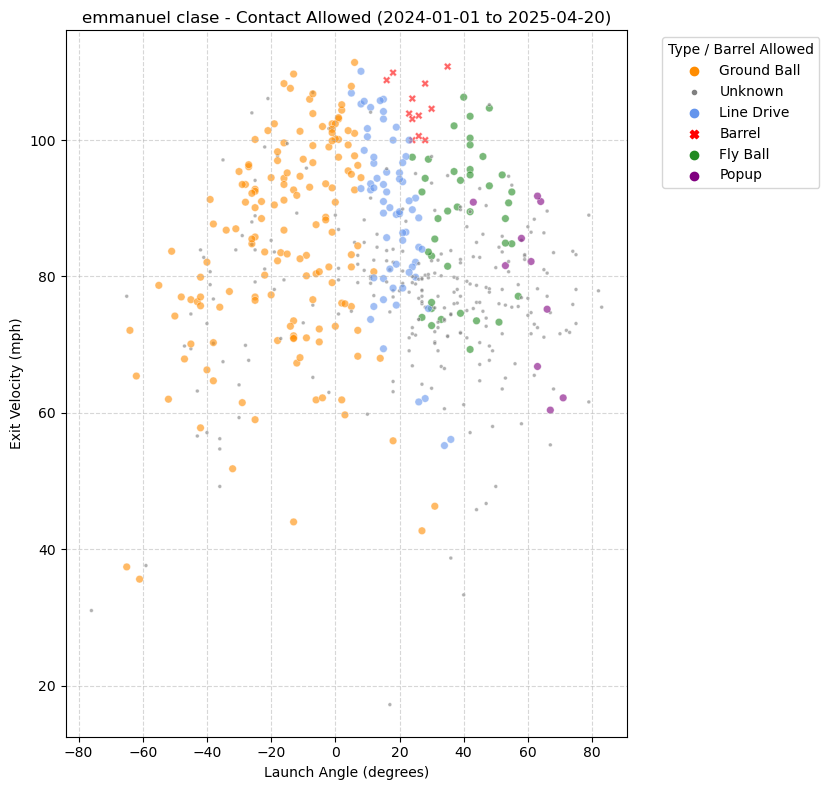


--- Rolling 50-BBE Hard Hit Rate Allowed ---


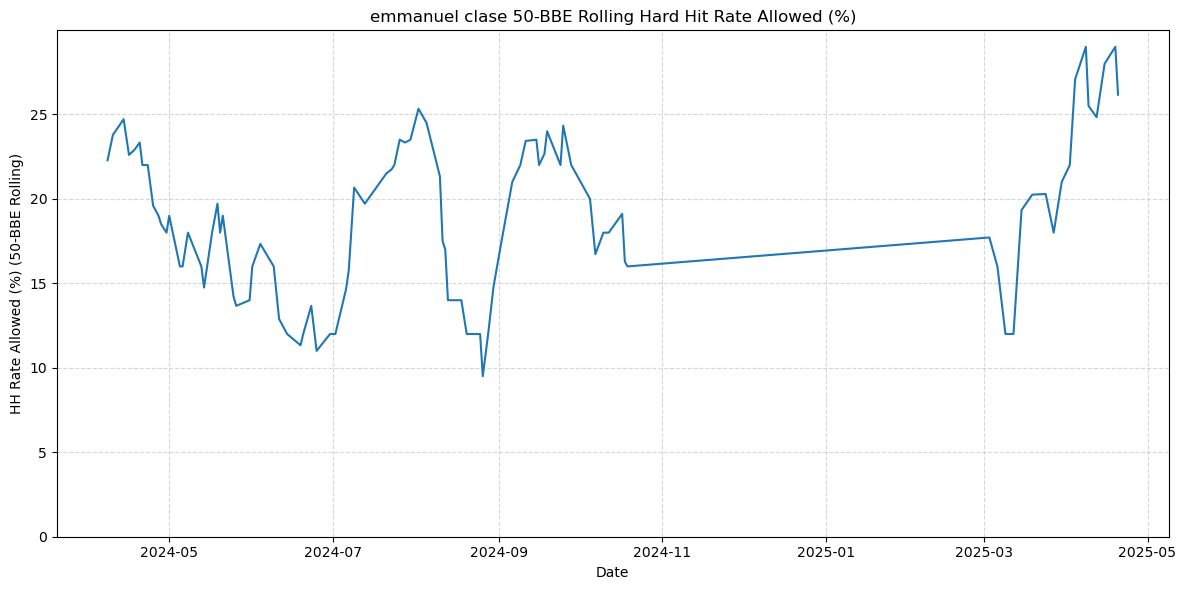


--- Rolling 50-BBE Barrel Rate Allowed ---


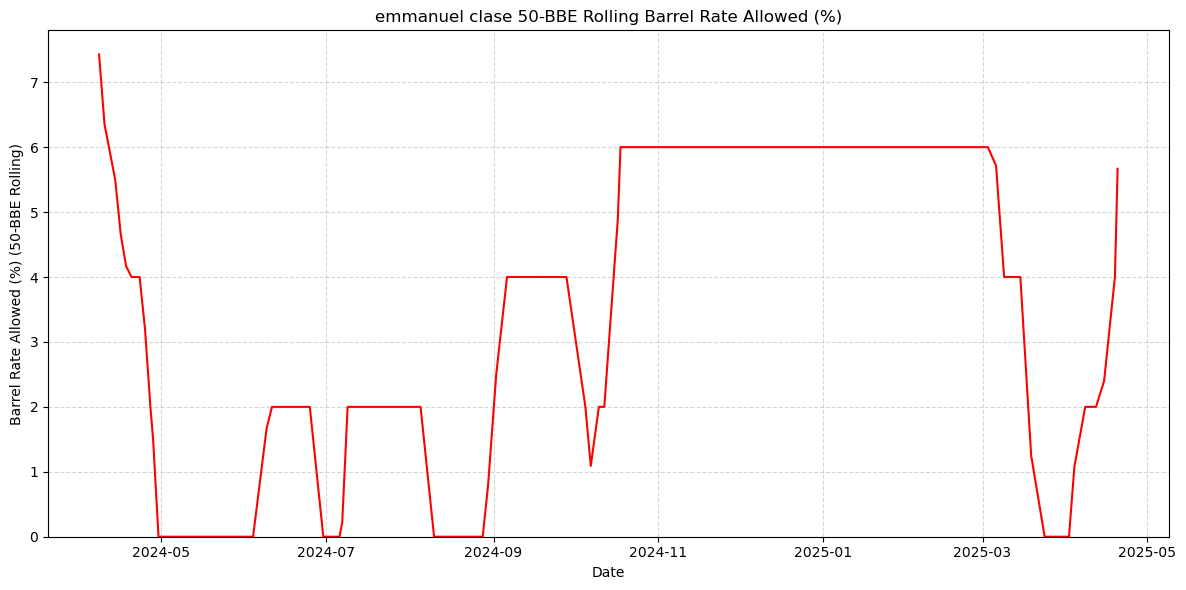

--- End of Block 5 ---


In [20]:
# Block 5: Contact Quality Allowed

print("\n--- Block 5: Analyzing Contact Quality Allowed ---")

# --- Define is_barrel function if not already defined ---
# (Copied from batter notebook Block 7a - run this part if needed)
if 'is_barrel' not in locals() and 'is_barrel' not in globals():
    print("Defining 'is_barrel' helper function...")
    import pandas as pd # Ensure pandas is available for isna
    import numpy as np # Ensure numpy is available for nan

    def is_barrel(launch_speed, launch_angle):
        """
        Determines if a batted ball is a Statcast Barrel based on approximate criteria.
        Args: launch_speed (float), launch_angle (float)
        Returns: bool
        """
        if pd.isna(launch_speed) or pd.isna(launch_angle): return False
        if launch_speed < 98: return False
        min_la_barrel = 0.0; max_la_barrel = 0.0
        if launch_speed >= 116:
            min_la_barrel = 8.0; max_la_barrel = 50.0
        elif launch_speed >= 100:
            min_la_barrel = 24.0 - (launch_speed - 100.0) * 1.0
            max_la_barrel = 33.0 + (launch_speed - 100.0) * 1.0625
        elif launch_speed == 99:
            min_la_barrel = 25.0; max_la_barrel = 31.0
        elif launch_speed == 98:
            min_la_barrel = 26.0; max_la_barrel = 30.0
        else: return False
        return (launch_angle >= min_la_barrel) and (launch_angle <= max_la_barrel)
    print("'is_barrel' function defined.")
# ---------------------------------------------------------


# Check prerequisite data and variables from Block 1
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Required Columns ---
    required_cols = ['launch_speed', 'launch_angle', 'bb_type', 'game_date']

    # Check if all required columns exist
    if all(col in pitcher_statcast_data.columns for col in required_cols):

        # --- Data Preparation: Filter for Batted Balls ---
        batted_ball_data_contact = pitcher_statcast_data[
            pitcher_statcast_data['launch_speed'].notna() &
            pitcher_statcast_data['launch_angle'].notna() &
            pitcher_statcast_data['game_date'].notna() # Needed for rolling plots
        ].copy()

        if not batted_ball_data_contact.empty:
            print(f"\nCalculating contact quality based on {len(batted_ball_data_contact)} batted balls allowed...")

            # --- Calculate Summary Metrics ---
            contact_metrics = {}
            contact_metrics["Batted Balls Allowed"] = len(batted_ball_data_contact)
            contact_metrics["Avg EV Allowed (mph)"] = batted_ball_data_contact['launch_speed'].mean()
            contact_metrics["Max EV Allowed (mph)"] = batted_ball_data_contact['launch_speed'].max()
            contact_metrics["Avg LA Allowed (deg)"] = batted_ball_data_contact['launch_angle'].mean()

            # Hard Hit Rate Allowed
            hard_hit_threshold = 95.0
            batted_ball_data_contact['is_hard_hit_allowed'] = batted_ball_data_contact['launch_speed'] >= hard_hit_threshold
            contact_metrics[f"Hard Hit Rate Allowed (%)"] = batted_ball_data_contact['is_hard_hit_allowed'].mean() * 100

            # Barrel Rate Allowed
            try:
                if 'is_barrel' in globals() and callable(globals()['is_barrel']):
                     batted_ball_data_contact['is_barrel_allowed'] = batted_ball_data_contact.apply(
                         lambda row: is_barrel(row['launch_speed'], row['launch_angle']), axis=1
                     )
                     contact_metrics["Barrel Rate Allowed (%)"] = batted_ball_data_contact['is_barrel_allowed'].mean() * 100
                else:
                    contact_metrics["Barrel Rate Allowed (%)"] = np.nan
                    print("Warning: 'is_barrel' function not defined. Cannot calculate Barrel Rate Allowed.")
            except Exception as e:
                 contact_metrics["Barrel Rate Allowed (%)"] = np.nan
                 print(f"Warning: Error calculating barrel rate allowed - {e}")

            # --- Display Summary Table ---
            summary_series_contact = pd.Series(contact_metrics)
            title_contact = f"Contact Quality Allowed Summary for {pitcher_first_name} {pitcher_last_name} ({start_date} to {end_date})"
            print("\n" + "="*len(title_contact))
            print(title_contact)
            print("="*len(title_contact))
            print(summary_series_contact.to_string(float_format="%.1f"))


            # --- EV vs LA Scatter Plot ---
            print("\n--- Exit Velocity vs Launch Angle Allowed Plot ---")
            # Create category for plotting barrels vs other types
            if 'is_barrel_allowed' in batted_ball_data_contact.columns: # Check if barrel calc succeeded
                 def assign_contact_category(row):
                      if row['is_barrel_allowed']: return "Barrel"
                      elif pd.notna(row['bb_type']): return row['bb_type'].replace('_',' ').title()
                      else: return "Unknown"
                 batted_ball_data_contact['contact_category'] = batted_ball_data_contact.apply(assign_contact_category, axis=1)
                 hue_col, style_col = 'contact_category', 'contact_category' # Color/style by barrel/bb_type
                 markers = {"Barrel": "X", "Line Drive": "o", "Fly Ball": "o", "Ground Ball": "o", "Popup": "o", "Unknown": "."}
                 palette = {"Barrel": "red", "Line Drive": "cornflowerblue", "Fly Ball": "forestgreen", "Ground Ball": "darkorange", "Popup": "purple", "Unknown": "grey"}
                 present_cats = batted_ball_data_contact['contact_category'].unique()
                 plot_palette = {k: v for k, v in palette.items() if k in present_cats}
                 plot_markers = {k: v for k, v in markers.items() if k in present_cats}
                 legend_title = "Type / Barrel Allowed"
            else:
                 # Fallback if barrel calc failed: just use bb_type
                 batted_ball_data_contact['contact_category'] = batted_ball_data_contact['bb_type'].fillna("Unknown").str.replace('_',' ').str.title()
                 hue_col, style_col = 'contact_category', None # Just color by bb_type
                 plot_palette = sns.color_palette("tab10", n_colors=batted_ball_data_contact['contact_category'].nunique()) # Default palette
                 plot_markers = None # Default markers
                 legend_title = "Batted Ball Type"


            plt.figure(figsize=(10, 8))
            sns.scatterplot(
                data=batted_ball_data_contact,
                x='launch_angle', y='launch_speed',
                hue=hue_col, style=style_col,
                palette=plot_palette, markers=plot_markers,
                s=30, alpha=0.6
            )
            plt.title(f"{pitcher_first_name} {pitcher_last_name} - Contact Allowed ({start_date} to {end_date})")
            plt.xlabel("Launch Angle (degrees)"); plt.ylabel("Exit Velocity (mph)")
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout(rect=[0, 0, 0.85, 1]); plt.show()


            # --- Rolling Plots ---
            # Ensure game_date is datetime and sort chronologically
            batted_ball_data_contact['game_date'] = pd.to_datetime(batted_ball_data_contact['game_date'])
            batted_ball_data_contact.sort_values(by='game_date', inplace=True)
            window_size_contact = 50 # Rolling window size (BBE)

            # Rolling Hard Hit Rate Allowed
            if len(batted_ball_data_contact) >= window_size_contact:
                print(f"\n--- Rolling {window_size_contact}-BBE Hard Hit Rate Allowed ---")
                rolling_hh_col = f'rolling_hhr_allowed_{window_size_contact}'
                batted_ball_data_contact[rolling_hh_col] = batted_ball_data_contact['is_hard_hit_allowed'].rolling(
                    window=window_size_contact, min_periods=window_size_contact // 2).mean() * 100
                daily_rolling_hh = batted_ball_data_contact.groupby('game_date')[rolling_hh_col].mean().reset_index()

                plt.figure(figsize=(12, 6))
                sns.lineplot(data=daily_rolling_hh, x='game_date', y=rolling_hh_col)
                plt.title(f"{pitcher_first_name} {pitcher_last_name} {window_size_contact}-BBE Rolling Hard Hit Rate Allowed (%)")
                plt.xlabel("Date"); plt.ylabel(f"HH Rate Allowed (%) ({window_size_contact}-BBE Rolling)"); plt.ylim(bottom=0)
                plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()
            else:
                print(f"\nNot enough batted ball data ({len(batted_ball_data_contact)}) for {window_size_contact}-BBE rolling Hard Hit Rate.")

            # Rolling Barrel Rate Allowed
            if 'is_barrel_allowed' in batted_ball_data_contact.columns and len(batted_ball_data_contact) >= window_size_contact:
                 print(f"\n--- Rolling {window_size_contact}-BBE Barrel Rate Allowed ---")
                 rolling_brl_col = f'rolling_brl_allowed_{window_size_contact}'
                 batted_ball_data_contact[rolling_brl_col] = batted_ball_data_contact['is_barrel_allowed'].rolling(
                     window=window_size_contact, min_periods=window_size_contact // 2).mean() * 100
                 daily_rolling_brl = batted_ball_data_contact.groupby('game_date')[rolling_brl_col].mean().reset_index()

                 plt.figure(figsize=(12, 6))
                 sns.lineplot(data=daily_rolling_brl, x='game_date', y=rolling_brl_col, color='red') # Different color
                 plt.title(f"{pitcher_first_name} {pitcher_last_name} {window_size_contact}-BBE Rolling Barrel Rate Allowed (%)")
                 plt.xlabel("Date"); plt.ylabel(f"Barrel Rate Allowed (%) ({window_size_contact}-BBE Rolling)"); plt.ylim(bottom=0)
                 plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()
            elif 'is_barrel_allowed' in batted_ball_data_contact.columns: # Enough data check failed
                 print(f"\nNot enough batted ball data ({len(batted_ball_data_contact)}) for {window_size_contact}-BBE rolling Barrel Rate.")
            # else barrel rate was not calculated due to missing function/error

        else:
            print(f"No batted balls with launch speed and launch angle data found for {pitcher_first_name} {pitcher_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in pitcher_statcast_data.columns]
        print(f"Skipping contact quality analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping contact quality analysis because pitcher data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping contact quality analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 5 ---")


--- Block 6: Analyzing Performance Outcomes ---
All required columns found.

Part 1: Preparing data for 50-Event Rolling wOBA vs xwOBA Allowed...
Calculating and plotting Rolling wOBA vs xwOBA Allowed...


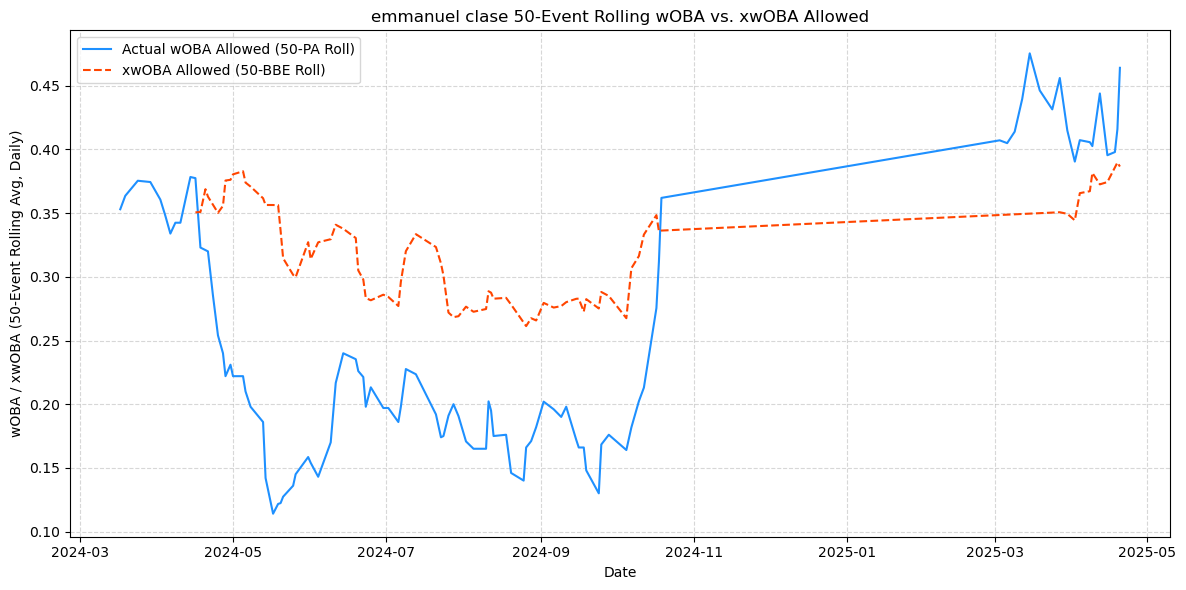


Part 2: Preparing data for 50-PA Rolling K% and BB%...
Calculating and plotting 50-PA Rolling K% and BB%...


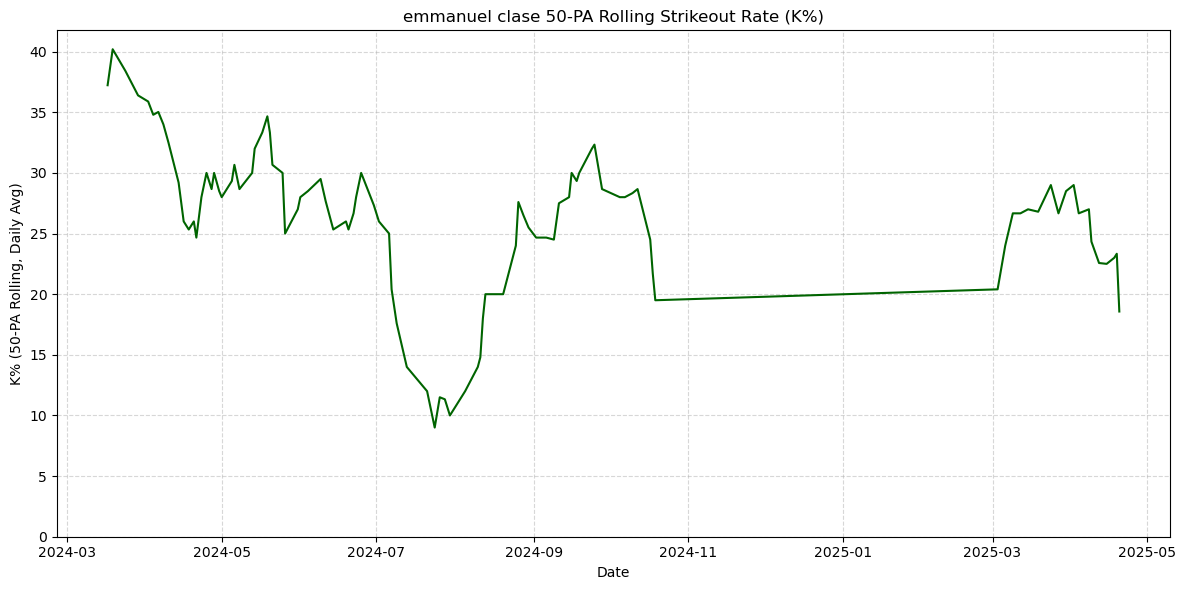

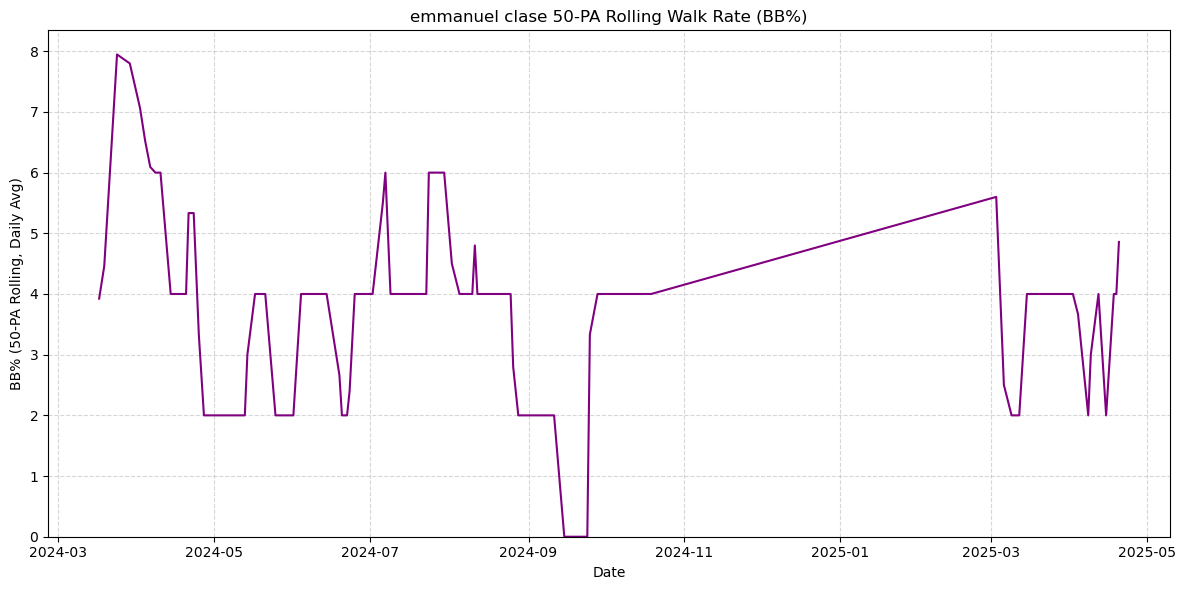

--- End of Block 6 ---


In [21]:
# Block 6: Performance Outcomes (Rolling wOBA/xwOBA, K%, BB%)

print("\n--- Block 6: Analyzing Performance Outcomes ---")

# Check prerequisite data and variables from Block 1
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Columns ---
    woba_col = 'woba_value' # Actual wOBA based on PA outcome
    xwoba_col = 'estimated_woba_using_speedangle' # Expected wOBA based on contact quality
    required_cols = [woba_col, xwoba_col, 'game_date', 'launch_speed', 'launch_angle', 'events',
                     'game_pk', 'at_bat_number'] # Need PA identifiers

    # Check if all required columns exist
    if all(col in pitcher_statcast_data.columns for col in required_cols):
        print("All required columns found.")

        # Define window size for rolling averages
        window_size = 50 # Use same window size (e.g., 50 events - PAs or BBEs)
        min_periods_calc = window_size // 2

        # --- Part 1: Rolling wOBA vs xwOBA Allowed ---
        print(f"\nPart 1: Preparing data for {window_size}-Event Rolling wOBA vs xwOBA Allowed...")
        # Prep Data for Rolling Actual wOBA
        pa_data_woba = pitcher_statcast_data[
            pitcher_statcast_data[woba_col].notna() &
            pitcher_statcast_data['game_date'].notna()
        ].copy()
        pa_data_woba['game_date'] = pd.to_datetime(pa_data_woba['game_date'])
        pa_data_woba.sort_values(by='game_date', inplace=True)

        # Prep Data for Rolling xwOBA
        batted_ball_data_rxwoba = pitcher_statcast_data[
            pitcher_statcast_data['launch_speed'].notna() &
            pitcher_statcast_data['launch_angle'].notna() &
            pitcher_statcast_data[xwoba_col].notna() &
            pitcher_statcast_data['game_date'].notna()
        ].copy()
        batted_ball_data_rxwoba['game_date'] = pd.to_datetime(batted_ball_data_rxwoba['game_date'])
        batted_ball_data_rxwoba.sort_values(by='game_date', inplace=True)

        can_calc_woba = len(pa_data_woba) >= window_size
        can_calc_xwoba = len(batted_ball_data_rxwoba) >= window_size

        if can_calc_woba and can_calc_xwoba:
            print("Calculating and plotting Rolling wOBA vs xwOBA Allowed...")
            # Calculate Rolling Averages
            rolling_woba_col = f'rolling_woba_allowed_{window_size}'
            rolling_xwoba_col = f'rolling_xwoba_allowed_{window_size}'
            pa_data_woba[rolling_woba_col] = pa_data_woba[woba_col].rolling(
                window=window_size, min_periods=min_periods_calc).mean()
            batted_ball_data_rxwoba[rolling_xwoba_col] = batted_ball_data_rxwoba[xwoba_col].rolling(
                window=window_size, min_periods=min_periods_calc).mean()

            # Aggregate daily
            daily_rolling_woba = pa_data_woba.groupby('game_date')[rolling_woba_col].mean().reset_index()
            daily_rolling_xwoba = batted_ball_data_rxwoba.groupby('game_date')[rolling_xwoba_col].mean().reset_index()

            # Visualization
            plt.figure(figsize=(12, 6))
            ax1 = plt.gca()
            sns.lineplot(data=daily_rolling_woba, x='game_date', y=rolling_woba_col, ax=ax1,
                         label=f'Actual wOBA Allowed ({window_size}-PA Roll)', color='dodgerblue')
            sns.lineplot(data=daily_rolling_xwoba, x='game_date', y=rolling_xwoba_col, ax=ax1,
                         label=f'xwOBA Allowed ({window_size}-BBE Roll)', color='orangered', linestyle='--')
            plt.title(f"{pitcher_first_name} {pitcher_last_name} {window_size}-Event Rolling wOBA vs. xwOBA Allowed")
            plt.xlabel("Date"); plt.ylabel(f"wOBA / xwOBA ({window_size}-Event Rolling Avg, Daily)")
            plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()
        else:
            if not can_calc_woba: print(f" Not enough Plate Appearance data ({len(pa_data_woba)}) for rolling wOBA.")
            if not can_calc_xwoba: print(f" Not enough Batted Ball data ({len(batted_ball_data_rxwoba)}) for rolling xwOBA.")


        # --- Part 2: Rolling K% and BB% ---
        print(f"\nPart 2: Preparing data for {window_size}-PA Rolling K% and BB%...")
        # Prep Data: Use PA outcomes (non-null events)
        pa_outcomes = pitcher_statcast_data[
            pitcher_statcast_data['events'].notna() &
            pitcher_statcast_data['game_date'].notna() &
            pitcher_statcast_data['game_pk'].notna() & # Needed for unique PA check
            pitcher_statcast_data['at_bat_number'].notna() # Needed for unique PA check
        ].copy()
        # Ensure one row per PA outcome (handle potential duplicates in source)
        pa_outcomes.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True)
        pa_outcomes.drop_duplicates(subset=['game_pk', 'at_bat_number'], keep='last', inplace=True)

        if not pa_outcomes.empty:
             # Ensure game_date is datetime and sort (sorting by date is primary for rolling)
             pa_outcomes['game_date'] = pd.to_datetime(pa_outcomes['game_date'])
             pa_outcomes.sort_values(by='game_date', inplace=True)

             # Define K and BB events
             # Using contains('strikeout') is safer for variants like strikeout_double_play
             pa_outcomes['is_k'] = pa_outcomes['events'].str.contains('strikeout', na=False)
             pa_outcomes['is_bb'] = pa_outcomes['events'].isin({'walk', 'intent_walk'})

             window_size_pa = window_size # Use the same window size based on PAs

             if len(pa_outcomes) >= window_size_pa:
                 print(f"Calculating and plotting {window_size_pa}-PA Rolling K% and BB%...")
                 # Calculate Rolling Rates
                 rolling_k_col = f'rolling_k_pct_{window_size_pa}'
                 rolling_bb_col = f'rolling_bb_pct_{window_size_pa}'

                 pa_outcomes[rolling_k_col] = pa_outcomes['is_k'].rolling(
                     window=window_size_pa, min_periods=min_periods_calc).mean() * 100
                 pa_outcomes[rolling_bb_col] = pa_outcomes['is_bb'].rolling(
                     window=window_size_pa, min_periods=min_periods_calc).mean() * 100

                 # Aggregate daily
                 daily_rolling_k = pa_outcomes.groupby('game_date')[rolling_k_col].mean().reset_index()
                 daily_rolling_bb = pa_outcomes.groupby('game_date')[rolling_bb_col].mean().reset_index()

                 # Visualize K%
                 plt.figure(figsize=(12, 6))
                 sns.lineplot(data=daily_rolling_k, x='game_date', y=rolling_k_col, color='darkgreen')
                 plt.title(f"{pitcher_first_name} {pitcher_last_name} {window_size_pa}-PA Rolling Strikeout Rate (K%)")
                 plt.xlabel("Date"); plt.ylabel(f"K% ({window_size_pa}-PA Rolling, Daily Avg)"); plt.ylim(bottom=0)
                 plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

                 # Visualize BB%
                 plt.figure(figsize=(12, 6))
                 sns.lineplot(data=daily_rolling_bb, x='game_date', y=rolling_bb_col, color='purple')
                 plt.title(f"{pitcher_first_name} {pitcher_last_name} {window_size_pa}-PA Rolling Walk Rate (BB%)")
                 plt.xlabel("Date"); plt.ylabel(f"BB% ({window_size_pa}-PA Rolling, Daily Avg)"); plt.ylim(bottom=0)
                 plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

             else:
                  print(f"\nNot enough plate appearance outcome data ({len(pa_outcomes)}) for {window_size_pa}-PA rolling K%/BB%.")

        else:
             print("\nNo plate appearance outcome data found to calculate K%/BB%.")

    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in pitcher_statcast_data.columns]
        print(f"Skipping performance outcome analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping performance outcome analysis because pitcher data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping performance outcome analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 6 ---")

In [33]:
# Block 7: Pitcher vs. League Average Comparison (Categorized Yearly Tables)

print("\n--- Block 7: Comparing Pitcher Metrics to League Averages (Categorized Yearly) ---")

# --- Define is_barrel function if not already defined ---
if 'is_barrel' not in locals() and 'is_barrel' not in globals():
    print("Defining 'is_barrel' helper function...")
    import pandas as pd; import numpy as np
    # (is_barrel function definition - assuming it's available)
    def is_barrel(launch_speed, launch_angle):
        if pd.isna(launch_speed) or pd.isna(launch_angle): return False
        if launch_speed < 98: return False
        min_la_barrel = 0.0; max_la_barrel = 0.0
        if launch_speed >= 116: min_la_barrel = 8.0; max_la_barrel = 50.0
        elif launch_speed >= 100:
            min_la_barrel = 24.0 - (launch_speed - 100.0) * 1.0
            max_la_barrel = 33.0 + (launch_speed - 100.0) * 1.0625
        elif launch_speed == 99: min_la_barrel = 25.0; max_la_barrel = 31.0
        elif launch_speed == 98: min_la_barrel = 26.0; max_la_barrel = 30.0
        else: return False
        return (launch_angle >= min_la_barrel) and (launch_angle <= max_la_barrel)
    print("'is_barrel' function defined.")
else:
    try: pd
    except NameError: import pandas as pd
    try: np
    except NameError: import numpy as np
# ---------------------------------------------------------

# --- Define Approx. Historical Pitcher League Averages ---
# (Using the expanded dictionary from the previous step)
pitcher_league_historical_avg = {
    2015: {"K%": 20.4, "BB%": 7.7, "CSW%": 27.0, "Whiff%": 20.5, "Chase%": 29.3, "Avg EV Allowed": 88.3, "Barrel% Allowed": 6.5, "Zone%": 48.0, "GB%": 44.5, "FB%": 34.5, "LD%": 21.0, "Avg LA Allowed": 10.5, "Avg Ext": 6.0, "Avg Velo FF": 92.5, "Avg Velo SI": 91.5, "Avg Velo FC": 87.8, "Avg Velo SL": 84.2, "Avg Velo CU": 77.6, "Avg Velo CH": 83.4, "Avg Velo FS": 84.4, "Avg Spin FF": 2230, "Avg Spin SI": 2120, "Avg Spin FC": 2190, "Avg Spin SL": 2400, "Avg Spin CU": 2500, "Avg Spin CH": 1750, "Avg Spin FS": 1520},
    2016: {"K%": 21.1, "BB%": 8.2, "CSW%": 27.3, "Whiff%": 21.0, "Chase%": 28.7, "Avg EV Allowed": 88.5, "Barrel% Allowed": 7.0, "Zone%": 48.2, "GB%": 44.5, "FB%": 34.5, "LD%": 21.0, "Avg LA Allowed": 10.8, "Avg Ext": 6.1, "Avg Velo FF": 92.8, "Avg Velo SI": 91.9, "Avg Velo FC": 87.9, "Avg Velo SL": 84.1, "Avg Velo CU": 77.9, "Avg Velo CH": 83.6, "Avg Velo FS": 84.5, "Avg Spin FF": 2240, "Avg Spin SI": 2130, "Avg Spin FC": 2200, "Avg Spin SL": 2425, "Avg Spin CU": 2510, "Avg Spin CH": 1760, "Avg Spin FS": 1530},
    2017: {"K%": 21.6, "BB%": 8.5, "CSW%": 27.5, "Whiff%": 21.5, "Chase%": 27.3, "Avg EV Allowed": 88.6, "Barrel% Allowed": 7.2, "Zone%": 48.5, "GB%": 44.0, "FB%": 35.0, "LD%": 21.0, "Avg LA Allowed": 11.2, "Avg Ext": 6.1, "Avg Velo FF": 93.2, "Avg Velo SI": 92.2, "Avg Velo FC": 88.4, "Avg Velo SL": 84.5, "Avg Velo CU": 78.0, "Avg Velo CH": 84.2, "Avg Velo FS": 84.3, "Avg Spin FF": 2250, "Avg Spin SI": 2140, "Avg Spin FC": 2210, "Avg Spin SL": 2450, "Avg Spin CU": 2520, "Avg Spin CH": 1770, "Avg Spin FS": 1540},
    2018: {"K%": 22.3, "BB%": 8.5, "CSW%": 27.7, "Whiff%": 22.0, "Chase%": 27.9, "Avg EV Allowed": 88.7, "Barrel% Allowed": 7.5, "Zone%": 48.5, "GB%": 44.0, "FB%": 35.0, "LD%": 21.0, "Avg LA Allowed": 11.8, "Avg Ext": 6.2, "Avg Velo FF": 93.1, "Avg Velo SI": 92.1, "Avg Velo FC": 88.7, "Avg Velo SL": 84.3, "Avg Velo CU": 79.0, "Avg Velo CH": 84.2, "Avg Velo FS": 85.5, "Avg Spin FF": 2260, "Avg Spin SI": 2150, "Avg Spin FC": 2220, "Avg Spin SL": 2475, "Avg Spin CU": 2530, "Avg Spin CH": 1780, "Avg Spin FS": 1550},
    2019: {"K%": 23.0, "BB%": 8.5, "CSW%": 28.0, "Whiff%": 22.5, "Chase%": 29.0, "Avg EV Allowed": 88.8, "Barrel% Allowed": 7.8, "Zone%": 48.0, "GB%": 43.5, "FB%": 35.5, "LD%": 21.0, "Avg LA Allowed": 12.7, "Avg Ext": 6.2, "Avg Velo FF": 93.1, "Avg Velo SI": 92.1, "Avg Velo FC": 88.5, "Avg Velo SL": 84.6, "Avg Velo CU": 79.1, "Avg Velo CH": 84.5, "Avg Velo FS": 85.6, "Avg Spin FF": 2280, "Avg Spin SI": 2160, "Avg Spin FC": 2230, "Avg Spin SL": 2480, "Avg Spin CU": 2540, "Avg Spin CH": 1790, "Avg Spin FS": 1580},
    2020: {"K%": 23.4, "BB%": 9.2, "CSW%": 28.3, "Whiff%": 23.0, "Chase%": 27.5, "Avg EV Allowed": 88.6, "Barrel% Allowed": 8.0, "Zone%": 48.0, "GB%": 43.5, "FB%": 35.5, "LD%": 21.0, "Avg LA Allowed": 12.7, "Avg Ext": 6.2, "Avg Velo FF": 93.4, "Avg Velo SI": 92.4, "Avg Velo FC": 88.3, "Avg Velo SL": 84.1, "Avg Velo CU": 79.2, "Avg Velo CH": 84.5, "Avg Velo FS": 85.3, "Avg Spin FF": 2300, "Avg Spin SI": 2180, "Avg Spin FC": 2250, "Avg Spin SL": 2490, "Avg Spin CU": 2530, "Avg Spin CH": 1800, "Avg Spin FS": 1600},
    2021: {"K%": 23.2, "BB%": 8.7, "CSW%": 28.5, "Whiff%": 23.0, "Chase%": 27.8, "Avg EV Allowed": 88.7, "Barrel% Allowed": 8.5, "Zone%": 48.5, "GB%": 43.5, "FB%": 35.5, "LD%": 21.0, "Avg LA Allowed": 12.5, "Avg Ext": 6.3, "Avg Velo FF": 93.5, "Avg Velo SI": 92.5, "Avg Velo FC": 88.5, "Avg Velo SL": 84.6, "Avg Velo CU": 79.3, "Avg Velo CH": 84.8, "Avg Velo FS": 85.9, "Avg Spin FF": 2310, "Avg Spin SI": 2190, "Avg Spin FC": 2260, "Avg Spin SL": 2500, "Avg Spin CU": 2540, "Avg Spin CH": 1800, "Avg Spin FS": 1600},
    2022: {"K%": 22.4, "BB%": 8.2, "CSW%": 28.3, "Whiff%": 23.5, "Chase%": 29.5, "Avg EV Allowed": 88.8, "Barrel% Allowed": 7.6, "Zone%": 48.7, "GB%": 44.0, "FB%": 35.0, "LD%": 21.0, "Avg LA Allowed": 12.6, "Avg Ext": 6.3, "Avg Velo FF": 93.6, "Avg Velo SI": 92.7, "Avg Velo FC": 88.9, "Avg Velo SL": 84.5, "Avg Velo CU": 79.5, "Avg Velo CH": 85.4, "Avg Velo FS": 86.9, "Avg Spin FF": 2280, "Avg Spin SI": 2160, "Avg Spin FC": 2240, "Avg Spin SL": 2520, "Avg Spin CU": 2545, "Avg Spin CH": 1780, "Avg Spin FS": 1610},
    2023: {"K%": 22.7, "BB%": 8.6, "CSW%": 28.0, "Whiff%": 23.0, "Chase%": 28.9, "Avg EV Allowed": 89.0, "Barrel% Allowed": 8.0, "Zone%": 49.0, "GB%": 44.0, "FB%": 35.0, "LD%": 21.0, "Avg LA Allowed": 12.3, "Avg Ext": 6.3, "Avg Velo FF": 94.1, "Avg Velo SI": 93.1, "Avg Velo FC": 89.0, "Avg Velo SL": 85.0, "Avg Velo CU": 79.8, "Avg Velo CH": 84.8, "Avg Velo FS": 86.0, "Avg Spin FF": 2290, "Avg Spin SI": 2170, "Avg Spin FC": 2250, "Avg Spin SL": 2530, "Avg Spin CU": 2550, "Avg Spin CH": 1750, "Avg Spin FS": 1600},
    2024: {"K%": 22.6, "BB%": 8.2, "CSW%": 28.0, "Whiff%": 23.0, "Chase%": 27.7, "Avg EV Allowed": 89.0, "Barrel% Allowed": 8.0, "Zone%": 49.5, "GB%": 44.0, "FB%": 35.0, "LD%": 21.0, "Avg LA Allowed": 12.5, "Avg Ext": 6.3, "Avg Velo FF": 94.0, "Avg Velo SI": 93.0, "Avg Velo FC": 88.5, "Avg Velo SL": 85.0, "Avg Velo CU": 79.5, "Avg Velo CH": 84.5, "Avg Velo FS": 85.0, "Avg Spin FF": 2300, "Avg Spin SI": 2160, "Avg Spin FC": 2250, "Avg Spin SL": 2530, "Avg Spin CU": 2550, "Avg Spin CH": 1750, "Avg Spin FS": 1600},
}
print("Defined approximate historical pitcher league averages (Expanded).")
# ---------------------------------------------------------

# Check prerequisite data and variables from Block 1
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Check for Historical Averages Dictionary ---
    league_avg_dict_available = 'pitcher_league_historical_avg' in locals() or 'pitcher_league_historical_avg' in globals()
    if not league_avg_dict_available:
        print("Error: Pitcher league historical average dictionary not found. Cannot proceed.")
    else:
        print("Found historical league average data.")

        # --- Ensure game_date is datetime and add year column ---
        if 'game_date' not in pitcher_statcast_data.columns:
             print("Error: 'game_date' column missing. Cannot proceed with yearly analysis.")
        else:
            pitcher_statcast_data['game_date'] = pd.to_datetime(pitcher_statcast_data['game_date'], errors='coerce')
            pitcher_statcast_data.dropna(subset=['game_date'], inplace=True) # Drop rows where date conversion failed
            pitcher_statcast_data['year'] = pitcher_statcast_data['game_date'].dt.year
            data_years = sorted(pitcher_statcast_data['year'].unique())
            print(f"Data covers years: {data_years}")

            # --- Initialize dictionaries to store results per year ---
            yearly_player_metrics = {}
            yearly_league_metrics = {} # Store league averages used for each year
            all_metrics_calculated = set() # Keep track of all metric keys encountered


            # --- Loop Through Each Year Present in the Data ---
            for year in data_years:
                print(f"\n--- Processing Year: {year} ---")
                year_league_avg = pitcher_league_historical_avg.get(year, {})
                yearly_league_metrics[year] = year_league_avg # Store for later table building
                if not year_league_avg:
                    print(f"  Warning: No league average data found for {year} in dictionary.")

                # Filter data for the current year
                yearly_data = pitcher_statcast_data[pitcher_statcast_data['year'] == year].copy()
                if yearly_data.empty:
                    print(f"  No data found for player in {year}. Skipping.")
                    continue

                # --- Calculate Player Metrics FOR THIS YEAR ---
                player_metrics_for_this_year = {} # Temp dict for this year

                # Check column availability for this year's slice
                present_cols_yr = yearly_data.columns
                has_spin_data_yr = 'release_spin_rate' in present_cols_yr
                has_contact_data_yr = all(col in present_cols_yr for col in ['launch_speed', 'launch_angle'])
                has_discipline_data_yr = all(col in present_cols_yr for col in ['description', 'zone'])
                has_pa_data_yr = all(col in present_cols_yr for col in ['events', 'game_pk', 'at_bat_number'])
                has_velo_data_yr = 'release_speed' in present_cols_yr
                has_extension_data_yr = 'release_pos_y' in present_cols_yr
                has_bb_type_data_yr = 'bb_type' in present_cols_yr

                # --- Perform calculations (logic copied from previous block, now on yearly_data) ---
                # K% and BB%
                if has_pa_data_yr:
                    pa_outcomes_yr = yearly_data[yearly_data['events'].notna()].copy()
                    pa_outcomes_yr.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True, na_position='last')
                    pa_outcomes_yr.drop_duplicates(subset=['game_pk', 'at_bat_number'], keep='last', inplace=True)
                    total_pa_yr = len(pa_outcomes_yr)
                    if total_pa_yr > 0:
                        pa_outcomes_yr['is_k'] = pa_outcomes_yr['events'].str.contains('strikeout', na=False)
                        pa_outcomes_yr['is_bb'] = pa_outcomes_yr['events'].isin({'walk', 'intent_walk'})
                        player_metrics_for_this_year["K%"] = (pa_outcomes_yr['is_k'].sum() / total_pa_yr * 100)
                        player_metrics_for_this_year["BB%"] = (pa_outcomes_yr['is_bb'].sum() / total_pa_yr * 100)
                    else: player_metrics_for_this_year["K%"], player_metrics_for_this_year["BB%"] = np.nan, np.nan
                else: player_metrics_for_this_year["K%"], player_metrics_for_this_year["BB%"] = np.nan, np.nan

                # Discipline Rates
                if has_discipline_data_yr:
                    pitch_data_pd_yr = yearly_data[yearly_data['description'].notna() & yearly_data['zone'].notna()].copy()
                    if not pitch_data_pd_yr.empty:
                        # (Calculations for CSW%, Whiff%, Chase%, Zone% - same as before but on pitch_data_pd_yr)
                        # ... (calculation logic omitted for brevity, ensure it uses yearly data) ...
                        swing_desc = {'hit_into_play','foul','swinging_strike','foul_tip','foul_bunt','missed_bunt','hit_into_play_no_out','hit_into_play_score'}
                        whiff_desc = {'swinging_strike', 'missed_bunt'}
                        pitch_data_pd_yr['is_swing'] = pitch_data_pd_yr['description'].isin(swing_desc)
                        pitch_data_pd_yr['is_whiff'] = pitch_data_pd_yr['description'].isin(whiff_desc)
                        pitch_data_pd_yr['is_csw'] = (pitch_data_pd_yr['description'] == 'called_strike') | pitch_data_pd_yr['is_whiff']
                        pitch_data_pd_yr['is_in_zone'] = (pitch_data_pd_yr['zone'] >= 1) & (pitch_data_pd_yr['zone'] <= 9)
                        pitch_data_pd_yr['is_out_of_zone'] = pitch_data_pd_yr['zone'] >= 11
                        total_pitches_yr=len(pitch_data_pd_yr); total_swings_yr=pitch_data_pd_yr['is_swing'].sum()
                        total_whiffs_yr=pitch_data_pd_yr['is_whiff'].sum(); total_csw_yr=pitch_data_pd_yr['is_csw'].sum()
                        pitches_out_zone_yr=pitch_data_pd_yr['is_out_of_zone'].sum(); swings_out_zone_yr=pitch_data_pd_yr.loc[pitch_data_pd_yr['is_out_of_zone'], 'is_swing'].sum()
                        pitches_in_zone_yr=pitch_data_pd_yr['is_in_zone'].sum()
                        player_metrics_for_this_year["CSW%"] = (total_csw_yr / total_pitches_yr * 100) if total_pitches_yr > 0 else np.nan
                        player_metrics_for_this_year["Whiff%"] = (total_whiffs_yr / total_swings_yr * 100) if total_swings_yr > 0 else np.nan
                        player_metrics_for_this_year["Chase%"] = (swings_out_zone_yr / pitches_out_zone_yr * 100) if pitches_out_zone_yr > 0 else np.nan
                        player_metrics_for_this_year["Zone%"] = (pitches_in_zone_yr / total_pitches_yr * 100) if total_pitches_yr > 0 else np.nan
                    else: player_metrics_for_this_year["CSW%"], player_metrics_for_this_year["Whiff%"], player_metrics_for_this_year["Chase%"], player_metrics_for_this_year["Zone%"] = np.nan, np.nan, np.nan, np.nan
                else: player_metrics_for_this_year["CSW%"], player_metrics_for_this_year["Whiff%"], player_metrics_for_this_year["Chase%"], player_metrics_for_this_year["Zone%"] = np.nan, np.nan, np.nan, np.nan

                # Contact Quality & Batted Ball Profile
                if has_contact_data_yr:
                    batted_ball_data_yr = yearly_data[yearly_data['launch_speed'].notna() & yearly_data['launch_angle'].notna()].copy()
                    if not batted_ball_data_yr.empty:
                        player_metrics_for_this_year["Avg EV Allowed"] = batted_ball_data_yr['launch_speed'].mean()
                        player_metrics_for_this_year["Avg LA Allowed"] = batted_ball_data_yr['launch_angle'].mean()
                        try:
                            if 'is_barrel' in globals() and callable(globals()['is_barrel']):
                                batted_ball_data_yr['is_barrel_allowed'] = batted_ball_data_yr.apply(lambda row: is_barrel(row['launch_speed'], row['launch_angle']), axis=1)
                                player_metrics_for_this_year["Barrel% Allowed"] = batted_ball_data_yr['is_barrel_allowed'].mean() * 100
                            else: player_metrics_for_this_year["Barrel% Allowed"] = np.nan
                        except NameError: player_metrics_for_this_year["Barrel% Allowed"] = np.nan

                        if has_bb_type_data_yr:
                            bb_type_dist_yr = batted_ball_data_yr['bb_type'].value_counts(normalize=True) * 100
                            bb_type_map = {'ground_ball': 'GB%', 'fly_ball': 'FB%', 'line_drive': 'LD%', 'popup': 'PU%'}
                            for key in bb_type_map.values(): player_metrics_for_this_year[key] = player_metrics_for_this_year.get(key, 0.0)
                            for bb_type, pct in bb_type_dist_yr.items():
                                if pd.notna(bb_type): metric_key = bb_type_map.get(bb_type);
                                if metric_key: player_metrics_for_this_year[metric_key] = pct
                        else: player_metrics_for_this_year["GB%"], player_metrics_for_this_year["FB%"], player_metrics_for_this_year["LD%"], player_metrics_for_this_year["PU%"] = np.nan, np.nan, np.nan, np.nan
                    else: player_metrics_for_this_year["Avg EV Allowed"], player_metrics_for_this_year["Avg LA Allowed"], player_metrics_for_this_year["Barrel% Allowed"] = np.nan, np.nan, np.nan
                else: player_metrics_for_this_year["Avg EV Allowed"], player_metrics_for_this_year["Avg LA Allowed"], player_metrics_for_this_year["Barrel% Allowed"] = np.nan, np.nan, np.nan

                # Avg Extension
                if has_extension_data_yr:
                    valid_release_y_yr = yearly_data['release_pos_y'].dropna()
                    if not valid_release_y_yr.empty: player_metrics_for_this_year["Avg Ext"] = (60.5 - valid_release_y_yr).mean()
                    else: player_metrics_for_this_year["Avg Ext"] = np.nan
                else: player_metrics_for_this_year["Avg Ext"] = np.nan

                # Pitch Specific Velo/Spin
                if 'pitch_type' in yearly_data.columns:
                    unique_pitches_yr = sorted(yearly_data['pitch_type'].dropna().unique())
                    if has_velo_data_yr:
                        velo_data_yr = yearly_data[yearly_data['release_speed'].notna() & yearly_data['pitch_type'].notna()]
                        if not velo_data_yr.empty:
                            avg_velocities_yr = velo_data_yr.groupby('pitch_type', observed=True)['release_speed'].mean()
                            for pitch_type, avg_velo in avg_velocities_yr.items():
                                key = f"Avg Velo {pitch_type}"; player_metrics_for_this_year[key] = avg_velo; all_metrics_calculated.add(key)
                    if has_spin_data_yr:
                        spin_data_yr = yearly_data[yearly_data['release_spin_rate'].notna() & yearly_data['pitch_type'].notna()]
                        if not spin_data_yr.empty:
                            avg_spins_yr = spin_data_yr.groupby('pitch_type', observed=True)['release_spin_rate'].mean()
                            for pitch_type, avg_spin in avg_spins_yr.items():
                                key = f"Avg Spin {pitch_type}"; player_metrics_for_this_year[key] = avg_spin; all_metrics_calculated.add(key)

                # Store this year's calculated player metrics
                yearly_player_metrics[year] = player_metrics_for_this_year
                # Update the set of all metric keys encountered across all years
                all_metrics_calculated.update(player_metrics_for_this_year.keys())


            # --- Post-Loop: Create and Print Categorized Tables ---
            print("\n--- Yearly Metric Comparison Tables ---")

            # Define categories and the standard keys belonging to them
            metric_categories = {
                "Overall Rates": ["K%", "BB%", "CSW%", "Zone%", "Chase%", "Whiff%"],
                "Contact Quality Allowed": ["Avg EV Allowed", "Avg LA Allowed", "Barrel% Allowed", "GB%", "FB%", "LD%", "PU%"],
                "Release Characteristics": ["Avg Ext"],
                "Pitch Velocity": sorted([k for k in all_metrics_calculated if k.startswith("Avg Velo ")]),
                "Pitch Spin Rate": sorted([k for k in all_metrics_calculated if k.startswith("Avg Spin ")])
            }

            # Define display details (can be expanded as needed)
            metric_display_details = {
                 "K%": {"display": "K%", "unit": "%", "fmt": ".1f"}, "BB%": {"display": "BB%", "unit": "%", "fmt": ".1f"},
                 "CSW%": {"display": "CSW%", "unit": "%", "fmt": ".1f"}, "Zone%": {"display": "Zone%", "unit": "%", "fmt": ".1f"},
                 "Chase%": {"display": "Chase% Induced", "unit": "%", "fmt": ".1f"}, "Whiff%": {"display": "Whiff% (per swing)", "unit": "%", "fmt": ".1f"},
                 "Avg EV Allowed": {"display": "Avg EV Allowed (mph)", "unit": "mph", "fmt": ".1f"}, "Avg LA Allowed": {"display": "Avg LA Allowed (deg)", "unit": "deg", "fmt": ".1f"},
                 "Barrel% Allowed": {"display": "Barrel% Allowed", "unit": "%", "fmt": ".1f"},
                 "GB%": {"display": "GB% Allowed", "unit": "%", "fmt": ".1f"}, "FB%": {"display": "FB% Allowed", "unit": "%", "fmt": ".1f"},
                 "LD%": {"display": "LD% Allowed", "unit": "%", "fmt": ".1f"}, "PU%": {"display": "PU% Allowed", "unit": "%", "fmt": ".1f"},
                 "Avg Ext": {"display": "Avg Extension (ft)", "unit": "ft", "fmt": ".1f"},
            }
            # Dynamically add display details for pitch types
            for k in all_metrics_calculated:
                if k not in metric_display_details:
                     parts = k.split(' ') # "Avg", "Velo/Spin", "PT"
                     unit = "mph" if parts[1] == "Velo" else ("rpm" if parts[1] == "Spin" else "")
                     fmt = ".0f" if unit == "rpm" else ".1f"
                     metric_display_details[k] = {"display": f"{k} ({unit})", "unit": unit, "fmt": fmt} # Key = "Avg Velo FF", Display = "Avg Velo FF (mph)"


            # Loop through categories and create tables
            for category_name, metric_keys in metric_categories.items():
                table_data = []
                valid_keys_in_category = [k for k in metric_keys if k in all_metrics_calculated] # Only show metrics that were actually calculated

                if not valid_keys_in_category: # Skip category if no relevant metrics were calculated
                     print(f"\nSkipping '{category_name}' table - no relevant metrics calculated.")
                     continue

                for key in valid_keys_in_category:
                    details = metric_display_details.get(key, {})
                    display_name = details.get("display", key)
                    fmt = details.get("fmt", ".1f")

                    row_dict = {'Metric': display_name} # Use display name for the row header

                    # Add columns for each year: Player (Year) | League (Year)
                    for year in data_years:
                        p_val = yearly_player_metrics.get(year, {}).get(key, np.nan)
                        lg_avg = yearly_league_metrics.get(year, {}).get(key, np.nan) # Lookup using standard key

                        row_dict[f'Player ({year})'] = f"{p_val:{fmt}}" if pd.notna(p_val) else "N/A"
                        row_dict[f'League ({year})'] = f"{lg_avg:{fmt}}" if pd.notna(lg_avg) else "N/A"

                    table_data.append(row_dict)

                if table_data:
                    df_category = pd.DataFrame(table_data)
                    # Print category header and table
                    print(f"\n\n--- {category_name} ---")
                    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None, 'display.width', 200): # Adjust width
                         print(df_category.to_markdown(index=False, numalign="center", stralign="left"))


else:
     print("Skipping pitcher comparison because prerequisite data/variables are missing or required columns not found.")

print("--- End of Block 7 ---")


--- Block 7: Comparing Pitcher Metrics to League Averages (Categorized Yearly) ---
Defined approximate historical pitcher league averages (Expanded).
Found historical league average data.
Data covers years: [2024, 2025]

--- Processing Year: 2024 ---

--- Processing Year: 2025 ---

--- Yearly Metric Comparison Tables ---


--- Overall Rates ---
| Metric             |  Player (2024)  |  League (2024)  |  Player (2025)  | League (2025)   |
|:-------------------|:---------------:|:---------------:|:---------------:|:----------------|
| K%                 |      25.7       |      22.6       |      23.8       | N/A             |
| BB%                |       3.5       |       8.2       |        6        | N/A             |
| CSW%               |       29        |       28        |      27.3       | N/A             |
| Zone%              |      54.5       |      49.5       |      53.5       | N/A             |
| Chase% Induced     |      37.4       |      27.7       |      35.5       | N/A  


--- Block 8: Analyzing Pitch Release Points (Separate Plot per Pitch Type) ---
Found 1403 pitches with release point data.
Pitch Types Found: FC, FF, SI, SL
Setting consistent plot limits: X=(-2.264, 0.064), Z=(5.664000000000001, 6.4559999999999995)

Generating plot for: FC (1078 pitches)


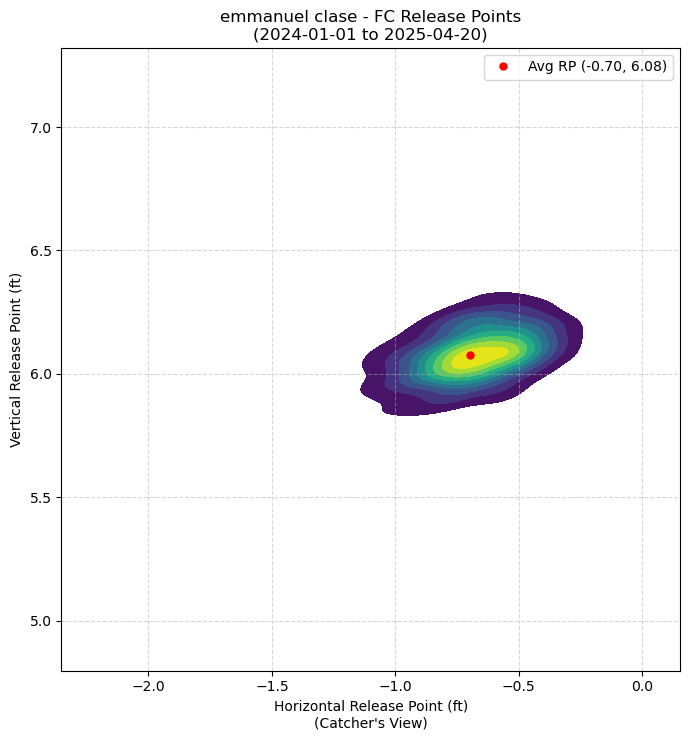


Generating plot for: FF (5 pitches)


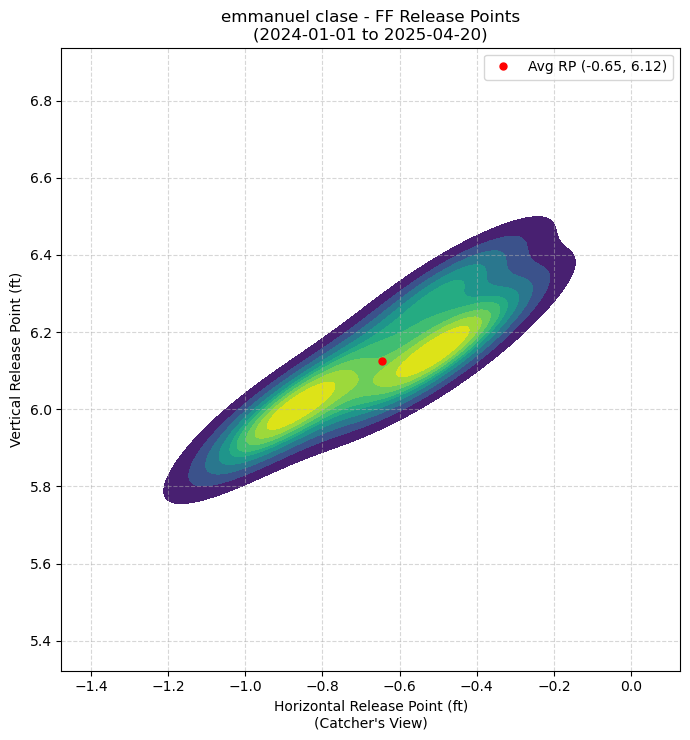


Generating plot for: SI (21 pitches)


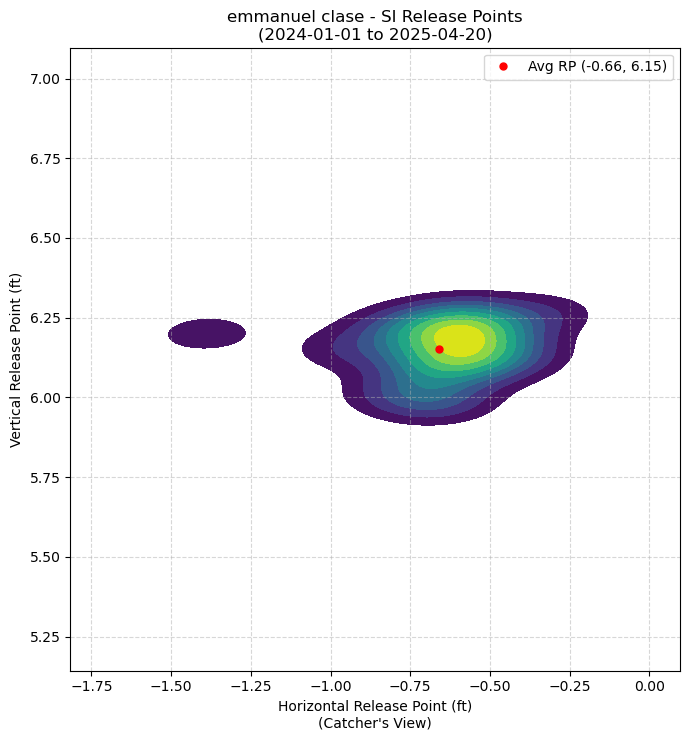


Generating plot for: SL (299 pitches)


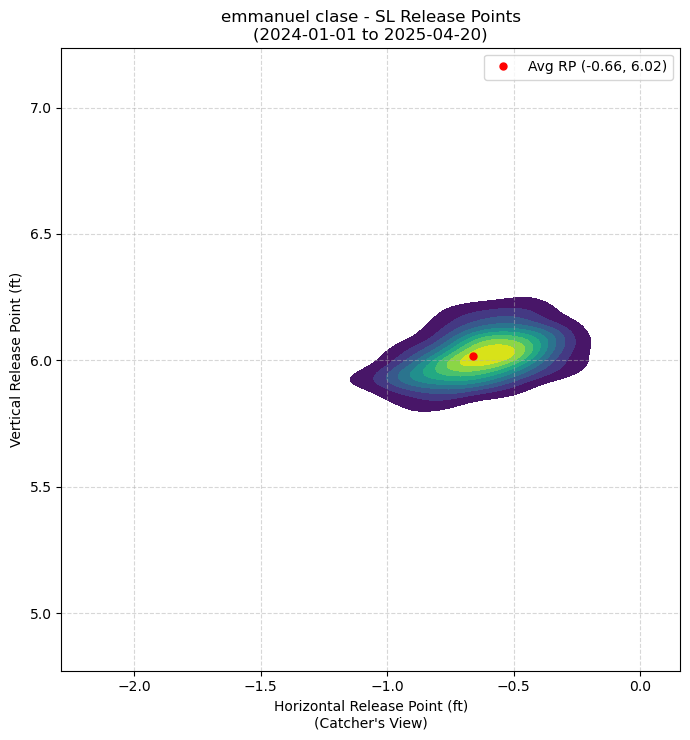

--- End of Block 8 ---


In [23]:
# Block 8: Visualize Release Points (Separate Plot per Pitch Type)

print("\n--- Block 8: Analyzing Pitch Release Points (Separate Plot per Pitch Type) ---")

# Check prerequisite data and variables from Block 1
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Required Columns ---
    required_cols = ['release_pos_x', 'release_pos_z', 'pitch_type']

    # Check if all required columns exist
    if all(col in pitcher_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        # Filter for pitches with valid release point data and pitch type
        release_data = pitcher_statcast_data[
            pitcher_statcast_data['release_pos_x'].notna() &
            pitcher_statcast_data['release_pos_z'].notna() &
            pitcher_statcast_data['pitch_type'].notna()
        ].copy()

        if not release_data.empty:
            print(f"Found {len(release_data)} pitches with release point data.")

            # Get unique pitch types, sort them
            unique_pitches = sorted(release_data['pitch_type'].unique())
            print(f"Pitch Types Found: {', '.join(unique_pitches)}")

            # --- Determine Consistent Axis Limits ---
            # Find overall min/max for x and z to keep plots comparable
            x_min, x_max = release_data['release_pos_x'].min(), release_data['release_pos_x'].max()
            z_min, z_max = release_data['release_pos_z'].min(), release_data['release_pos_z'].max()
            # Add a small buffer
            x_buffer = (x_max - x_min) * 0.1
            z_buffer = (z_max - z_min) * 0.1
            plot_xlim = (x_min - x_buffer, x_max + x_buffer)
            plot_ylim = (z_min - z_buffer, z_max + z_buffer)
            print(f"Setting consistent plot limits: X={plot_xlim}, Z={plot_ylim}")


            # --- Loop Through Pitch Types and Plot ---
            for pitch_name in unique_pitches:
                pitch_specific_data = release_data[release_data['pitch_type'] == pitch_name]
                pitch_count = len(pitch_specific_data)
                print(f"\nGenerating plot for: {pitch_name} ({pitch_count} pitches)")

                # Need at least a few points for KDE to work well
                if pitch_count < 5:
                    print(f"  -> Skipping KDE plot for {pitch_name} due to insufficient data points ({pitch_count}).")
                    continue

                try:
                    plt.figure(figsize=(7, 7.5)) # Square figure, bit taller for title
                    ax_rel = plt.gca()

                    # Create KDE plot for this specific pitch type
                    sns.kdeplot(
                        data=pitch_specific_data,
                        x='release_pos_x',
                        y='release_pos_z',
                        fill=True,          # Shade the density areas
                        cmap='viridis',     # Use a single sequential colormap
                        thresh=0.1,         # Adjust density threshold
                        ax=ax_rel
                    )

                    # Optionally: Add a marker for the average release point of this pitch
                    avg_x = pitch_specific_data['release_pos_x'].mean()
                    avg_z = pitch_specific_data['release_pos_z'].mean()
                    ax_rel.plot(avg_x, avg_z, 'ro', markersize=5, label=f'Avg RP ({avg_x:.2f}, {avg_z:.2f})')

                    # Apply consistent limits and aspect ratio
                    plt.xlim(plot_xlim)
                    plt.ylim(plot_ylim)
                    plt.axis('equal')

                    plt.title(f"{pitcher_first_name} {pitcher_last_name} - {pitch_name} Release Points\n({start_date} to {end_date})")
                    plt.xlabel("Horizontal Release Point (ft)\n(Catcher's View)")
                    plt.ylabel("Vertical Release Point (ft)")
                    plt.grid(True, linestyle='--', alpha=0.5)
                    plt.legend()
                    plt.tight_layout()
                    plt.show()

                except Exception as e:
                     print(f"  -> Could not generate plot for {pitch_name}. Error: {e}")


        else:
            print(f"No pitches with valid release point data found for {pitcher_first_name} {pitcher_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in pitcher_statcast_data.columns]
        print(f"Skipping release point analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping release point analysis because pitcher data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping release point analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 8 ---")


--- Block 8: Analyzing Pitch Release Points (Scatter Plot per Pitch Type) ---
Found 1403 pitches with release point data.
Pitch Types Found: FC, FF, SI, SL
Setting consistent plot limits: X=(-2.264, 0.064), Z=(5.664000000000001, 6.4559999999999995)

Generating plot for: FC (1078 pitches)


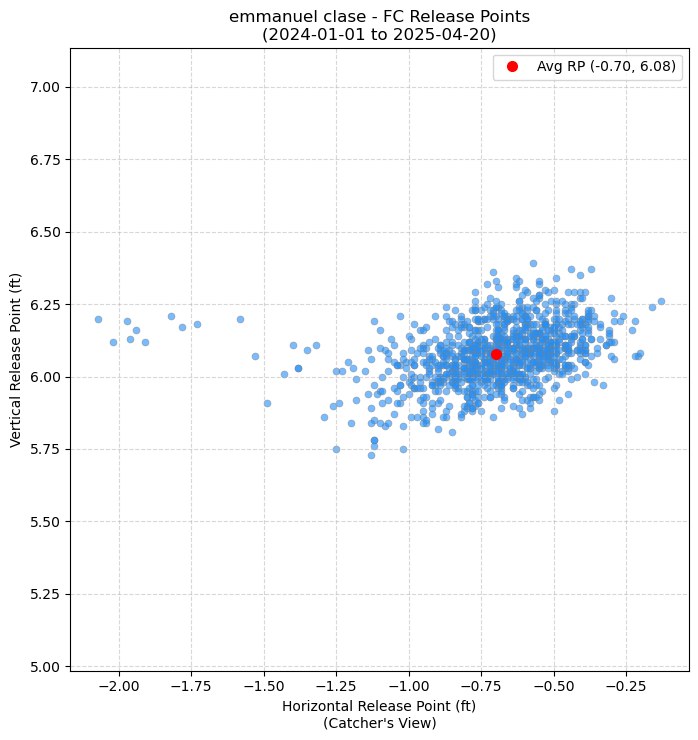


Generating plot for: FF (5 pitches)


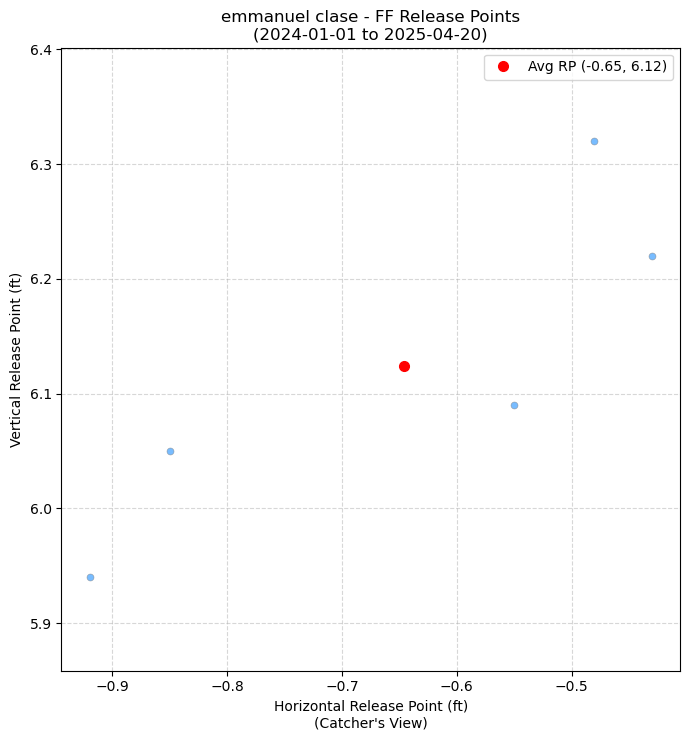


Generating plot for: SI (21 pitches)


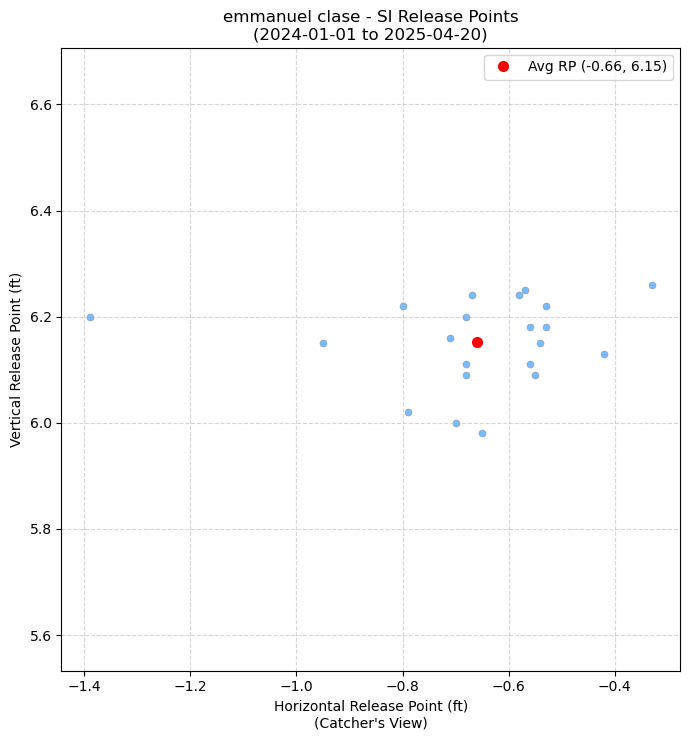


Generating plot for: SL (299 pitches)


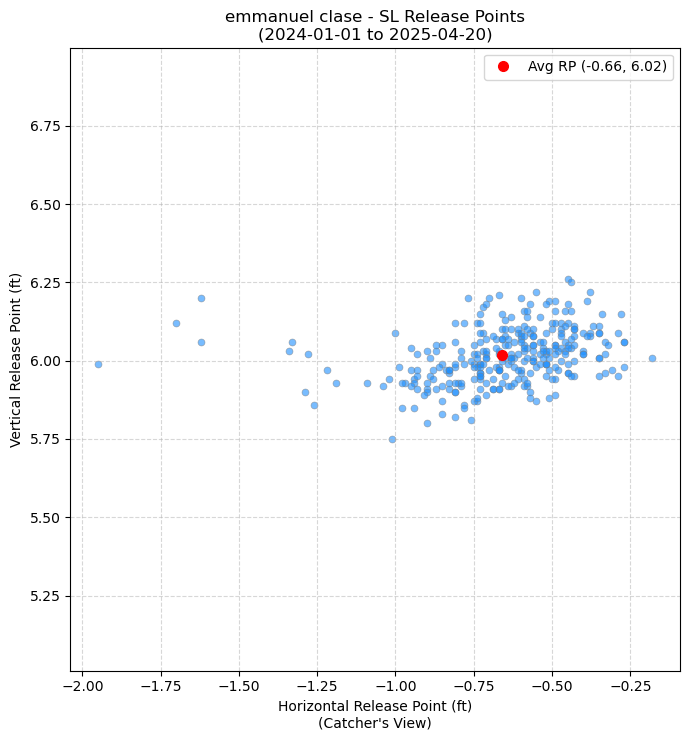

--- End of Block 8 ---


In [24]:
# Block 8: Visualize Release Points (Scatter Plot per Pitch Type)

print("\n--- Block 8: Analyzing Pitch Release Points (Scatter Plot per Pitch Type) ---")

# Check prerequisite data and variables from Block 1
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Required Columns ---
    required_cols = ['release_pos_x', 'release_pos_z', 'pitch_type']

    # Check if all required columns exist
    if all(col in pitcher_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        # Filter for pitches with valid release point data and pitch type
        release_data = pitcher_statcast_data[
            pitcher_statcast_data['release_pos_x'].notna() &
            pitcher_statcast_data['release_pos_z'].notna() &
            pitcher_statcast_data['pitch_type'].notna()
        ].copy()

        if not release_data.empty:
            print(f"Found {len(release_data)} pitches with release point data.")

            # Get unique pitch types, sort them
            unique_pitches = sorted(release_data['pitch_type'].unique())
            print(f"Pitch Types Found: {', '.join(unique_pitches)}")

            # --- Determine Consistent Axis Limits ---
            x_min, x_max = release_data['release_pos_x'].min(), release_data['release_pos_x'].max()
            z_min, z_max = release_data['release_pos_z'].min(), release_data['release_pos_z'].max()
            x_buffer = (x_max - x_min) * 0.1; z_buffer = (z_max - z_min) * 0.1
            plot_xlim = (x_min - x_buffer, x_max + x_buffer)
            plot_ylim = (z_min - z_buffer, z_max + z_buffer)
            print(f"Setting consistent plot limits: X={plot_xlim}, Z={plot_ylim}")


            # --- Loop Through Pitch Types and Plot ---
            for pitch_name in unique_pitches:
                pitch_specific_data = release_data[release_data['pitch_type'] == pitch_name]
                pitch_count = len(pitch_specific_data)
                print(f"\nGenerating plot for: {pitch_name} ({pitch_count} pitches)")

                if pitch_count < 1: # Need at least one point to plot
                    print(f"  -> Skipping scatter plot for {pitch_name} due to no data points.")
                    continue

                try:
                    plt.figure(figsize=(7, 7.5))
                    ax_rel = plt.gca()

                    # --- Create Scatter Plot --- ## MODIFIED PLOT TYPE ##
                    sns.scatterplot(
                        data=pitch_specific_data,
                        x='release_pos_x',
                        y='release_pos_z',
                        s=25,               # Point size
                        alpha=0.6,          # Transparency for overlaps
                        color="dodgerblue", # Use a consistent color for points
                        edgecolor="grey",   # Add edge color (optional)
                        linewidth=0.5,      # Edge line width (optional)
                        ax=ax_rel,
                        legend=False        # Don't add scatter points themselves to legend
                    )

                    # Add a marker for the average release point of this pitch
                    avg_x = pitch_specific_data['release_pos_x'].mean()
                    avg_z = pitch_specific_data['release_pos_z'].mean()
                    ax_rel.plot(avg_x, avg_z, 'ro', markersize=7, label=f'Avg RP ({avg_x:.2f}, {avg_z:.2f})')

                    # Apply consistent limits and aspect ratio
                    plt.xlim(plot_xlim)
                    plt.ylim(plot_ylim)
                    plt.axis('equal')

                    plt.title(f"{pitcher_first_name} {pitcher_last_name} - {pitch_name} Release Points\n({start_date} to {end_date})")
                    plt.xlabel("Horizontal Release Point (ft)\n(Catcher's View)")
                    plt.ylabel("Vertical Release Point (ft)")
                    plt.grid(True, linestyle='--', alpha=0.5)
                    plt.legend() # Show legend for the average point marker
                    plt.tight_layout()
                    plt.show()

                except Exception as e:
                     print(f"  -> Could not generate plot for {pitch_name}. Error: {e}")


        else:
            print(f"No pitches with valid release point data found for {pitcher_first_name} {pitcher_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in pitcher_statcast_data.columns]
        print(f"Skipping release point analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping release point analysis because pitcher data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping release point analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 8 ---")


--- Block 9: Analyzing Pitch Location by Pitch Type ---
Found 1403 pitches with location data.
Pitch Types Found: FC, FF, SI, SL

Generating plot for: FC (1078 pitches)


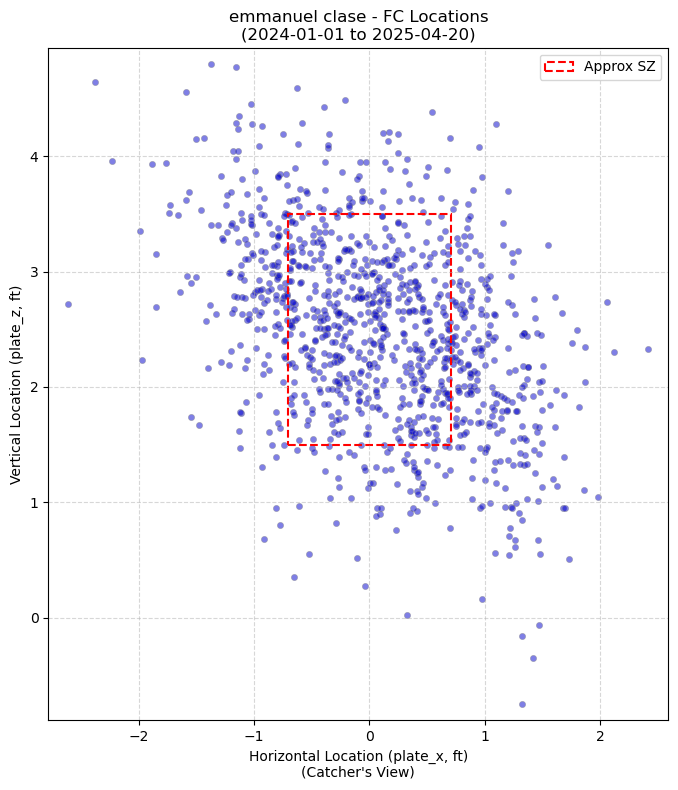


Generating plot for: FF (5 pitches)


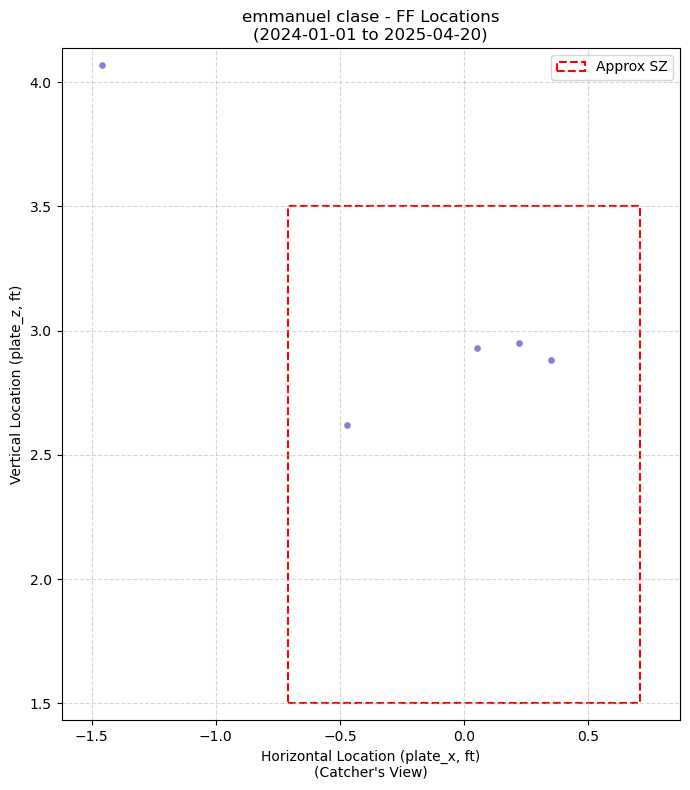


Generating plot for: SI (21 pitches)


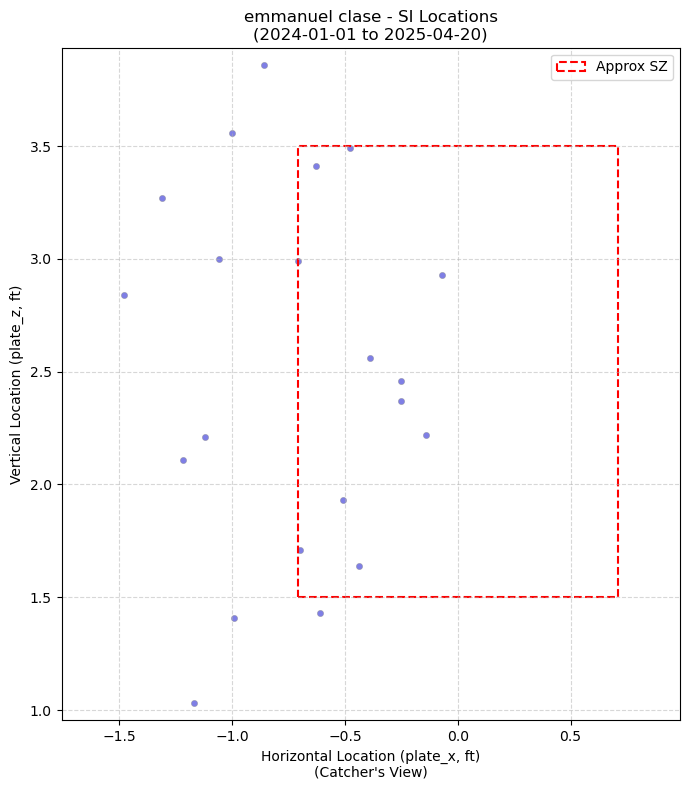


Generating plot for: SL (299 pitches)


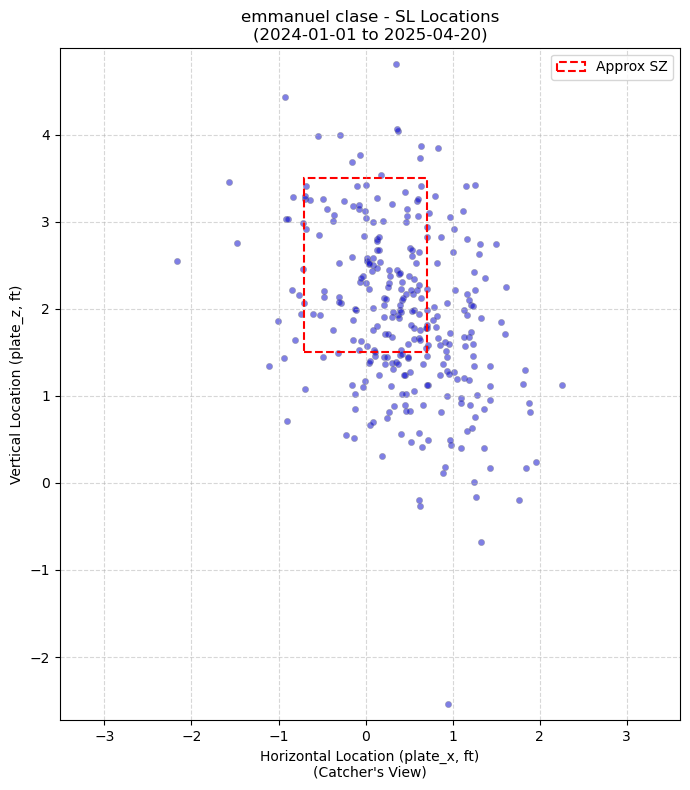

--- End of Block 9 ---


In [25]:
# Block 9: Pitch Location Scatter Plot (per Pitch Type)

print("\n--- Block 9: Analyzing Pitch Location by Pitch Type ---")

# Check prerequisite data and variables from Block 1
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Required Columns ---
    required_cols = ['plate_x', 'plate_z', 'pitch_type']

    # Check if all required columns exist
    if all(col in pitcher_statcast_data.columns for col in required_cols):

        # --- Data Preparation ---
        # Filter for pitches with valid location data and pitch type
        location_data = pitcher_statcast_data[
            pitcher_statcast_data['plate_x'].notna() &
            pitcher_statcast_data['plate_z'].notna() &
            pitcher_statcast_data['pitch_type'].notna()
        ].copy()

        if not location_data.empty:
            print(f"Found {len(location_data)} pitches with location data.")

            # Get unique pitch types, sort them
            unique_pitches = sorted(location_data['pitch_type'].unique())
            print(f"Pitch Types Found: {', '.join(unique_pitches)}")

            # Define approximate strike zone boundaries for plotting
            sz_x_min, sz_x_max = -17/24, 17/24 # Plate width (17in) / 2, converted to feet
            sz_z_min, sz_z_max = 1.5, 3.5     # Approximate vertical zone boundaries

            # Define consistent plot limits focusing on the plate area
            plot_xlim = (-2.5, 2.5)
            plot_ylim = (0, 5.0)


            # --- Loop Through Pitch Types and Plot ---
            for pitch_name in unique_pitches:
                pitch_specific_loc_data = location_data[location_data['pitch_type'] == pitch_name]
                pitch_count = len(pitch_specific_loc_data)
                print(f"\nGenerating plot for: {pitch_name} ({pitch_count} pitches)")

                if pitch_count < 1:
                    print(f"  -> Skipping plot for {pitch_name} due to no data points.")
                    continue

                try:
                    plt.figure(figsize=(7, 8)) # Keep consistent size
                    ax_loc = plt.gca()

                    # Create Scatter Plot for this pitch type
                    sns.scatterplot(
                        data=pitch_specific_loc_data,
                        x='plate_x',
                        y='plate_z',
                        s=20,               # Point size
                        alpha=0.5,          # Transparency for overlaps
                        color="mediumblue", # Use a consistent color for points
                        edgecolor="grey",   # Add edge color (optional)
                        linewidth=0.5,      # Edge line width (optional)
                        ax=ax_loc,
                        legend=False        # No legend needed for single pitch type points
                    )

                    # Add approximate strike zone overlay
                    sz_rect = plt.Rectangle((sz_x_min, sz_z_min), (sz_x_max - sz_x_min), (sz_z_max - sz_z_min),
                                            edgecolor='red', linestyle='--', fill=False, linewidth=1.5, label='Approx SZ')
                    ax_loc.add_patch(sz_rect)

                    # Apply consistent limits and aspect ratio
                    plt.xlim(plot_xlim)
                    plt.ylim(plot_ylim)
                    plt.axis('equal')

                    plt.title(f"{pitcher_first_name} {pitcher_last_name} - {pitch_name} Locations\n({start_date} to {end_date})")
                    plt.xlabel("Horizontal Location (plate_x, ft)\n(Catcher's View)")
                    plt.ylabel("Vertical Location (plate_z, ft)")
                    plt.grid(True, linestyle='--', alpha=0.5)
                    plt.legend(handles=[sz_rect]) # Show legend only for strike zone box
                    plt.tight_layout()
                    plt.show()

                except Exception as e:
                     print(f"  -> Could not generate plot for {pitch_name}. Error: {e}")


        else:
            print(f"No pitches with valid location data found for {pitcher_first_name} {pitcher_last_name} "
                  f"in the period {start_date} to {end_date}.")
    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in pitcher_statcast_data.columns]
        print(f"Skipping pitch location analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping pitch location analysis because pitcher data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping pitch location analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 9 ---")


--- Block 10: Analyzing Pitch Location by Outcome ---
Preparing data and calculating barrel info...

Generating plot for pitches resulting in: Barrel
  -> Plotting 12 pitches...


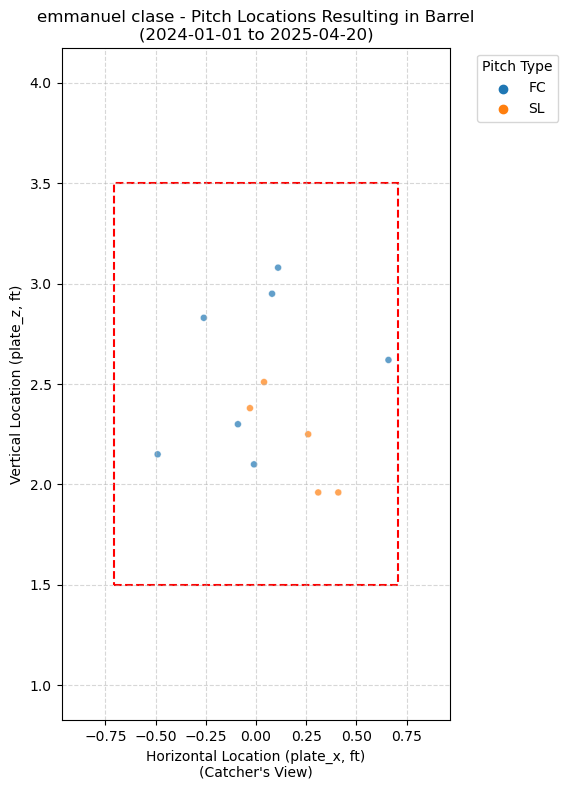


Generating plot for pitches resulting in: Line Drive
  -> Plotting 66 pitches...


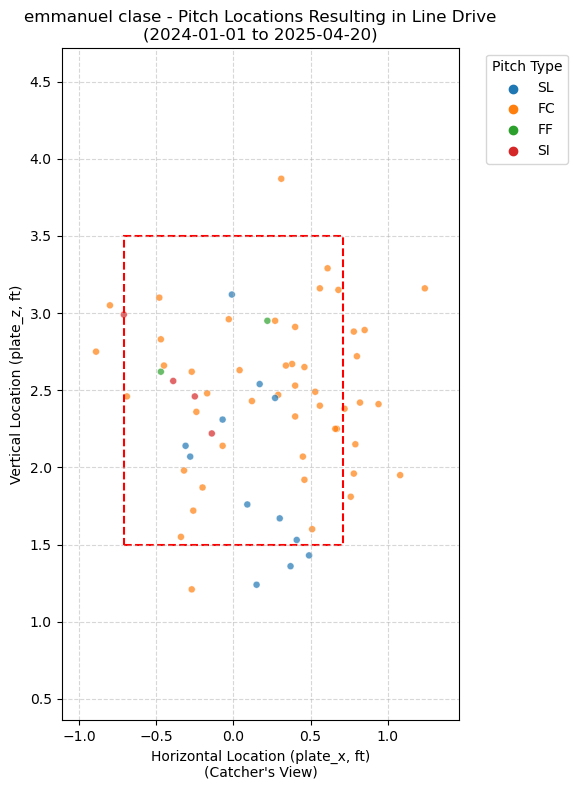


Generating plot for pitches resulting in: Fly Ball
  -> Plotting 40 pitches...


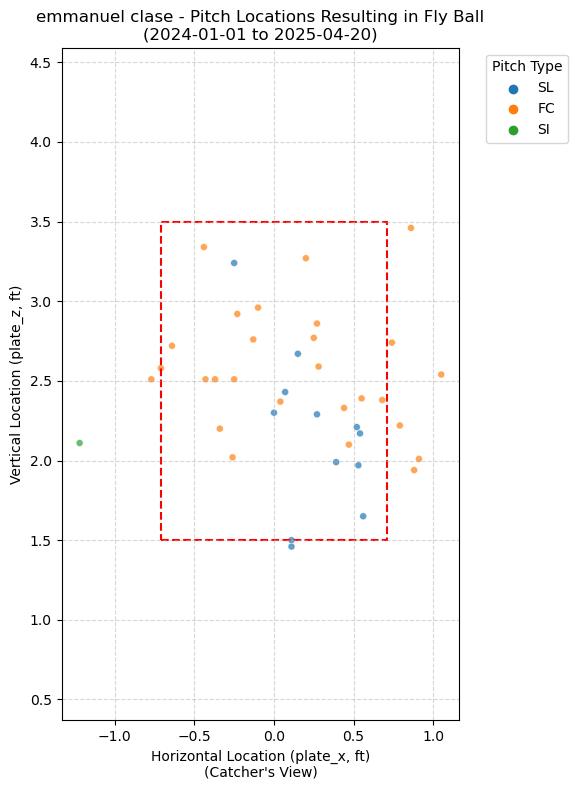


Generating plot for pitches resulting in: Ground Ball
  -> Plotting 150 pitches...


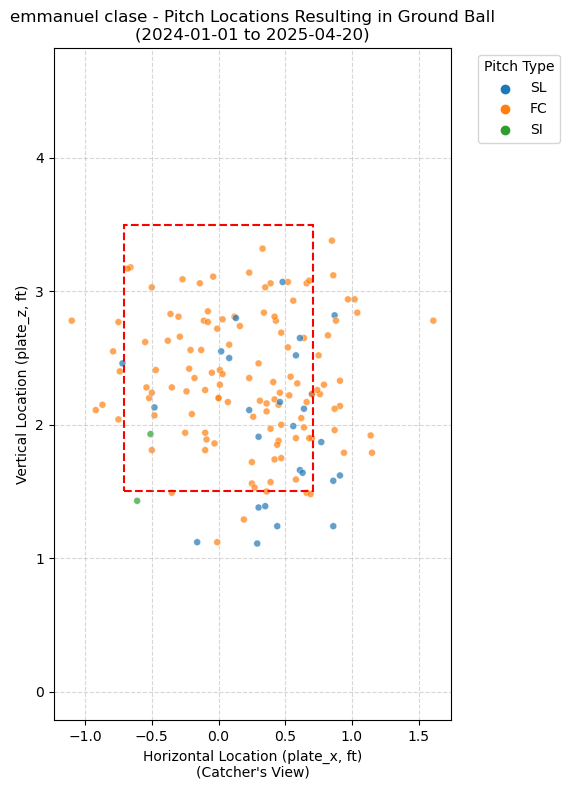


Generating plot for pitches resulting in: Popup
  -> Plotting 10 pitches...


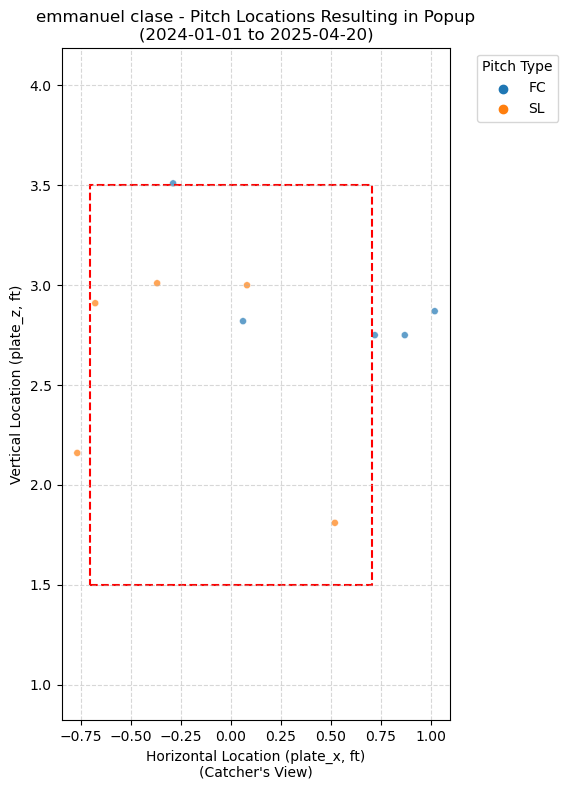


Generating plot for pitches resulting in: Strikeout
  -> Plotting 94 pitches...


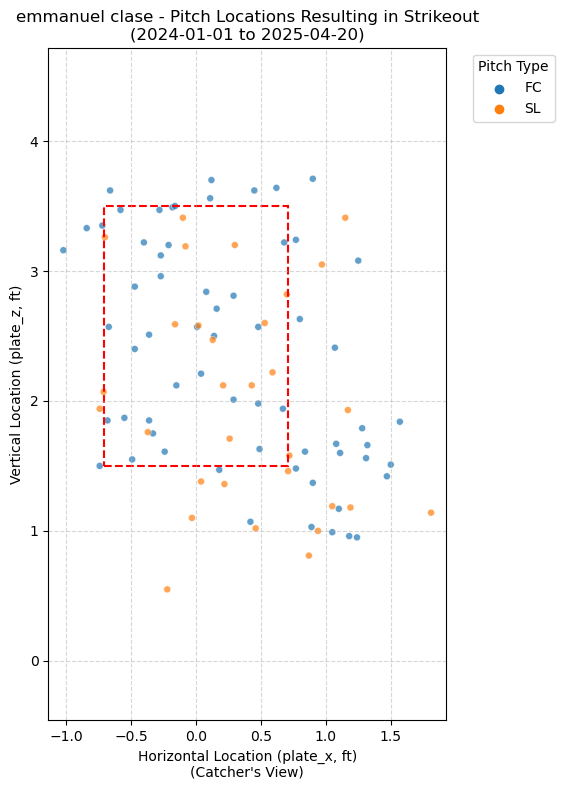


Generating plot for pitches resulting in: Walk
  -> Plotting 14 pitches...


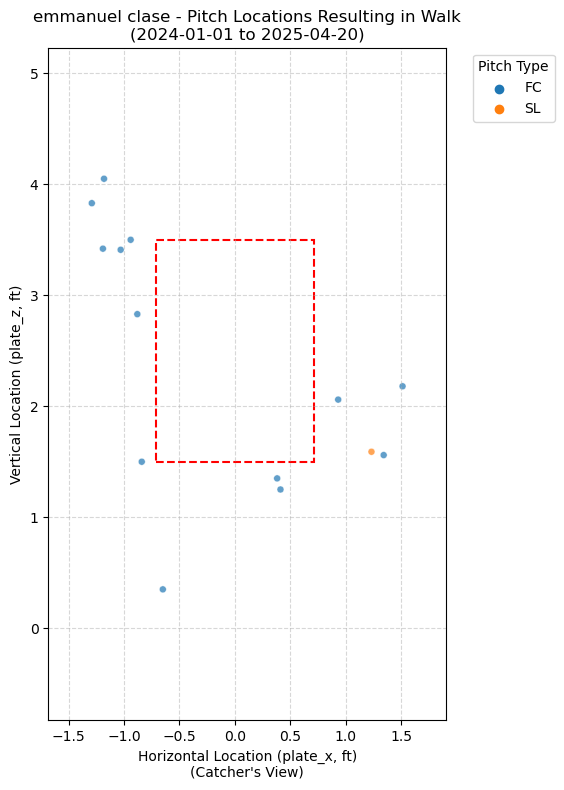


Generating plot for pitches resulting in: Whiff
  -> Plotting 200 pitches...


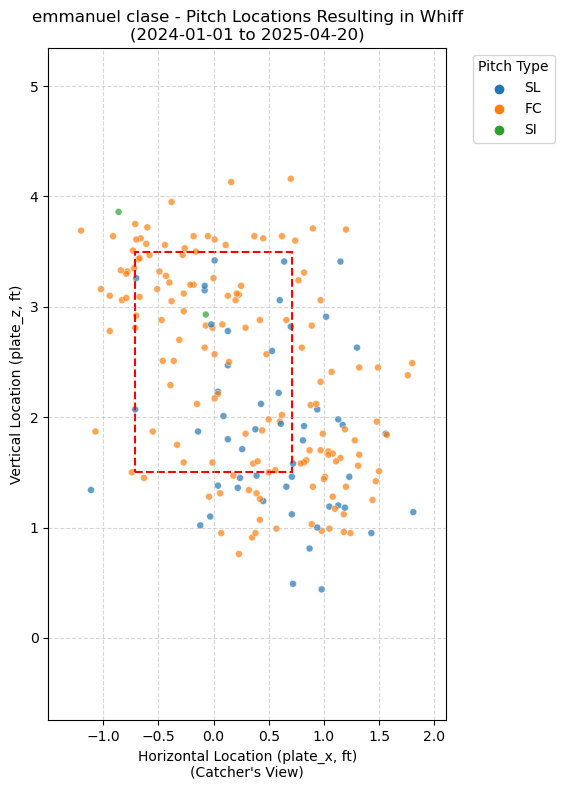

--- End of Block 10 ---


In [26]:
# Block 10: Pitch Location by Outcome Category

print("\n--- Block 10: Analyzing Pitch Location by Outcome ---")

# Check prerequisite data and variables from Block 1
# (Assuming checks for pitcher_statcast_data, names, dates passed)
# Also assumes is_barrel function is available (from Block 5 or 7)

if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'is_barrel' in locals() and callable(globals()['is_barrel']) and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Required Columns ---
    required_cols = ['plate_x', 'plate_z', 'pitch_type', 'events', 'description',
                     'bb_type', 'launch_speed', 'launch_angle', 'game_pk', 'at_bat_number', 'pitch_number'] # Added pitch_number

    # Check if all required columns exist
    if all(col in pitcher_statcast_data.columns for col in required_cols):

        # --- Data Preparation (add is_barrel column first) ---
        print("Preparing data and calculating barrel info...")
        loc_outcome_base_data = pitcher_statcast_data[
            pitcher_statcast_data['plate_x'].notna() &
            pitcher_statcast_data['plate_z'].notna() &
            pitcher_statcast_data['pitch_type'].notna()
            # Keep other columns needed for outcome definition
        ].copy()

        # Calculate is_barrel only for batted balls in this subset
        batted_balls = loc_outcome_base_data['launch_speed'].notna() & loc_outcome_base_data['launch_angle'].notna()
        loc_outcome_base_data['is_barrel_allowed'] = False # Initialize column
        if batted_balls.any():
             loc_outcome_base_data.loc[batted_balls, 'is_barrel_allowed'] = loc_outcome_base_data.loc[batted_balls].apply(
                 lambda row: is_barrel(row['launch_speed'], row['launch_angle']), axis=1
             )

        # Define outcome categories to plot
        outcome_categories = [
            "Barrel", "Line Drive", "Fly Ball", "Ground Ball", "Popup",
            "Strikeout", "Walk", "Whiff"
        ]

        # Define consistent plot limits and strike zone
        sz_x_min, sz_x_max = -17/24, 17/24
        sz_z_min, sz_z_max = 1.5, 3.5
        plot_xlim = (-2.5, 2.5)
        plot_ylim = (0, 5.0)

        # --- Loop Through Outcomes and Plot ---
        for outcome in outcome_categories:
            print(f"\nGenerating plot for pitches resulting in: {outcome}")
            outcome_data = pd.DataFrame() # Initialize empty DataFrame for this outcome

            try:
                # --- Filter data based on outcome category ---
                if outcome == "Barrel":
                    outcome_data = loc_outcome_base_data[loc_outcome_base_data['is_barrel_allowed'] == True]
                elif outcome == "Line Drive":
                    outcome_data = loc_outcome_base_data[(loc_outcome_base_data['bb_type'] == 'line_drive') & (loc_outcome_base_data['is_barrel_allowed'] == False)]
                elif outcome == "Fly Ball":
                    outcome_data = loc_outcome_base_data[(loc_outcome_base_data['bb_type'] == 'fly_ball') & (loc_outcome_base_data['is_barrel_allowed'] == False)]
                elif outcome == "Ground Ball":
                    outcome_data = loc_outcome_base_data[loc_outcome_base_data['bb_type'] == 'ground_ball']
                elif outcome == "Popup":
                    outcome_data = loc_outcome_base_data[loc_outcome_base_data['bb_type'] == 'popup']
                elif outcome == "Strikeout":
                    # Need PA ending pitches resulting in K
                    pa_ends_k = loc_outcome_base_data[loc_outcome_base_data['events'].notna()].copy()
                    pa_ends_k.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True, na_position='last')
                    pa_ends_k.drop_duplicates(subset=['game_pk', 'at_bat_number'], keep='last', inplace=True)
                    outcome_data = pa_ends_k[pa_ends_k['events'].str.contains('strikeout', na=False)]
                elif outcome == "Walk":
                     # Need PA ending pitches resulting in BB
                    pa_ends_bb = loc_outcome_base_data[loc_outcome_base_data['events'].notna()].copy()
                    pa_ends_bb.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True, na_position='last')
                    pa_ends_bb.drop_duplicates(subset=['game_pk', 'at_bat_number'], keep='last', inplace=True)
                    outcome_data = pa_ends_bb[pa_ends_bb['events'].isin({'walk', 'intent_walk'})]
                elif outcome == "Whiff":
                    # Any pitch resulting in a swinging strike / missed bunt
                    outcome_data = loc_outcome_base_data[loc_outcome_base_data['description'].isin({'swinging_strike', 'missed_bunt'})]

                # --- Generate Plot if data exists ---
                if not outcome_data.empty:
                    pitch_count = len(outcome_data)
                    print(f"  -> Plotting {pitch_count} pitches...")

                    plt.figure(figsize=(7, 8))
                    ax_outcome = plt.gca()

                    sns.scatterplot(
                        data=outcome_data,
                        x='plate_x',
                        y='plate_z',
                        hue='pitch_type', # Color points by pitch type
                        palette='tab10',  # Use a palette suitable for categories
                        s=25,
                        alpha=0.7,
                        ax=ax_outcome
                        # legend='full' # Let seaborn handle legend based on hue
                    )

                    # Add strike zone overlay
                    sz_rect = plt.Rectangle((sz_x_min, sz_z_min), (sz_x_max - sz_x_min), (sz_z_max - sz_z_min),
                                            edgecolor='red', linestyle='--', fill=False, linewidth=1.5) # No label needed here
                    ax_outcome.add_patch(sz_rect)

                    # Formatting
                    plt.xlim(plot_xlim)
                    plt.ylim(plot_ylim)
                    plt.axis('equal')
                    plt.title(f"{pitcher_first_name} {pitcher_last_name} - Pitch Locations Resulting in {outcome}\n({start_date} to {end_date})")
                    plt.xlabel("Horizontal Location (plate_x, ft)\n(Catcher's View)")
                    plt.ylabel("Vertical Location (plate_z, ft)")
                    plt.grid(True, linestyle='--', alpha=0.5)
                    plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend
                    plt.show()

                else:
                    print(f"  -> No pitches found resulting in outcome: {outcome}")

            except Exception as e:
                 print(f"  -> Could not generate plot for outcome {outcome}. Error: {e}")

    else:
        missing = [col for col in required_cols if col not in pitcher_statcast_data.columns]
        print(f"Skipping outcome location analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping outcome location analysis because pitcher data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or is_barrel func missing etc.
     if 'is_barrel' not in locals() or not callable(globals()['is_barrel']):
          print("Skipping outcome location analysis because 'is_barrel' function is not defined.")
     else:
          print("Skipping outcome location analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 10 ---")


--- Block 11: Analyzing Yearly Pitch Location by Pitch Type (Individual Plots) ---

Applying threshold: Keeping year/pitch type combos with >= 20 pitches.
Years with pitch types meeting threshold: [2024, 2025]

--- Generating Plots for Year: 2024 ---
  Plotting FC (860 pitches)...


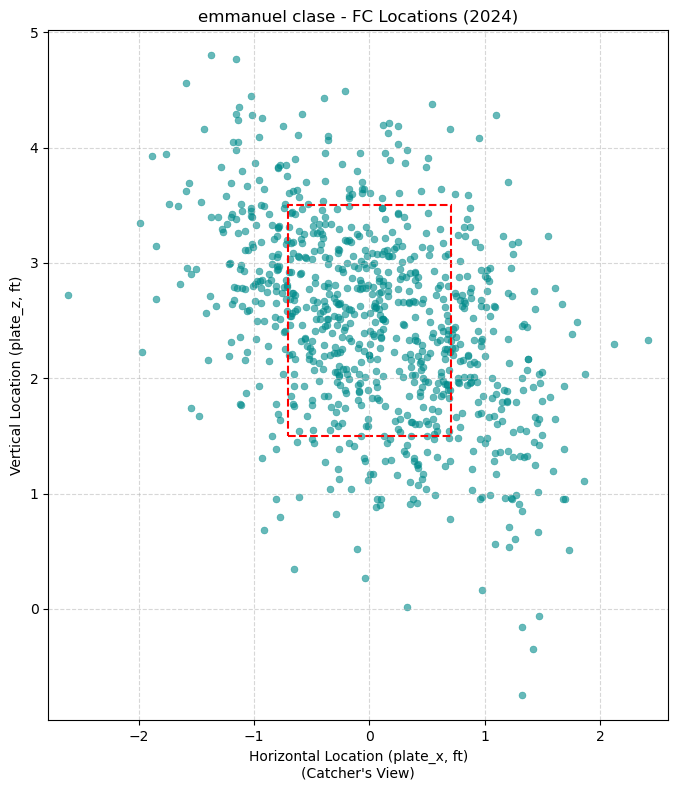

  Plotting SL (226 pitches)...


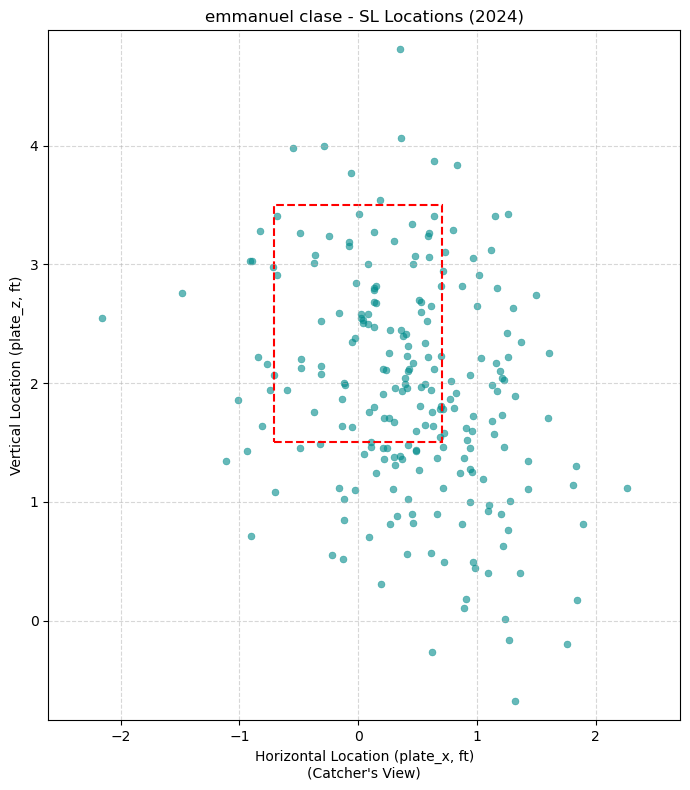


--- Generating Plots for Year: 2025 ---
  Plotting FC (218 pitches)...


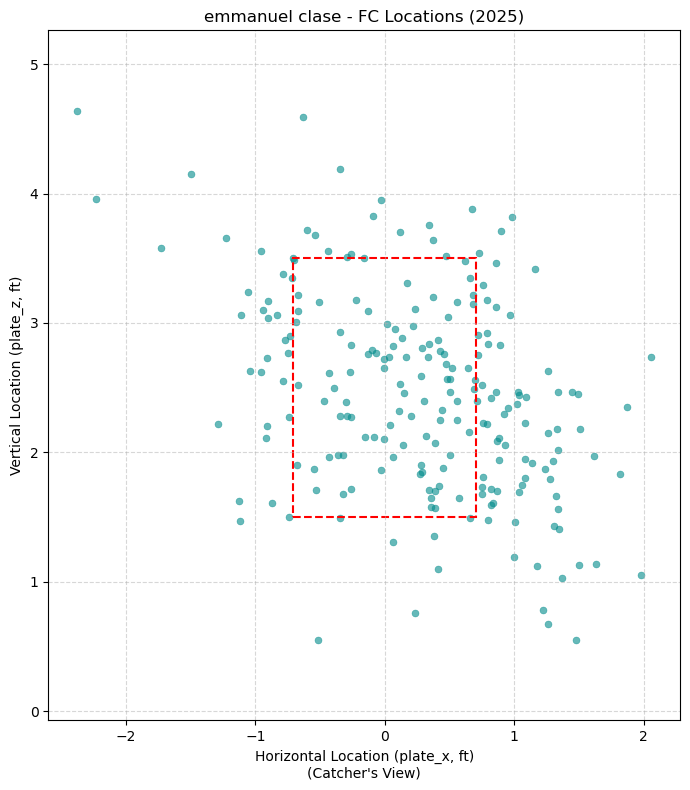

  Plotting SL (73 pitches)...


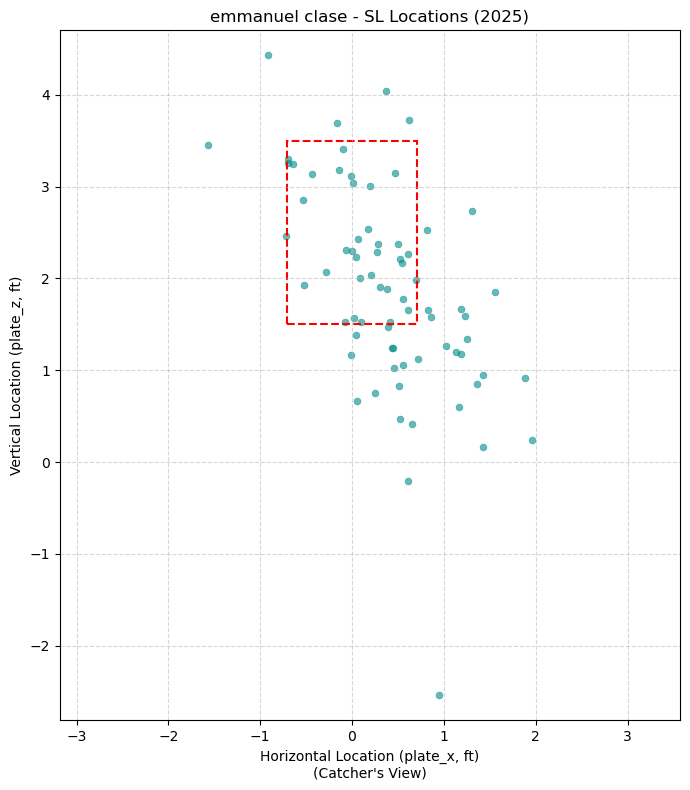

--- End of Block 11 ---


In [35]:
# Block 11: Yearly Pitch Location Comparison (Individual Scatter Plots)

print("\n--- Block 11: Analyzing Yearly Pitch Location by Pitch Type (Individual Plots) ---")

# Check prerequisite data and variables from Block 1
# (Assuming checks for pitcher_statcast_data, names, dates passed)
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Required Columns ---
    required_cols = ['plate_x', 'plate_z', 'pitch_type', 'game_date']

    # Check if all required columns exist
    if all(col in pitcher_statcast_data.columns for col in required_cols):

        # --- Data Preparation & Thresholding ---
        # 1. Filter for pitches with valid location data and pitch type
        location_data = pitcher_statcast_data[
            pitcher_statcast_data['plate_x'].notna() &
            pitcher_statcast_data['plate_z'].notna() &
            pitcher_statcast_data['pitch_type'].notna() &
            pitcher_statcast_data['game_date'].notna() # Also need date
        ].copy()

        # 2. Extract Year (handle potential errors)
        try:
            location_data['game_date'] = pd.to_datetime(location_data['game_date'], errors='coerce')
            location_data.dropna(subset=['game_date'], inplace=True) # Drop if date conversion failed
            location_data['year'] = location_data['game_date'].dt.year
        except Exception as e:
            print(f"Error processing game_date: {e}. Cannot proceed with yearly analysis.")
            location_data = pd.DataFrame() # Make empty to skip plotting

        if not location_data.empty:
            # 3. Apply Pitch Count Threshold per Year/Pitch Type
            pitch_threshold = 20
            print(f"\nApplying threshold: Keeping year/pitch type combos with >= {pitch_threshold} pitches.")
            location_data['count_per_year_pitch'] = location_data.groupby(['year', 'pitch_type'], observed=True)['pitch_type'].transform('size')
            location_data_filtered = location_data[location_data['count_per_year_pitch'] >= pitch_threshold].copy()

            if not location_data_filtered.empty:
                # Get unique years remaining after threshold
                data_years = sorted(location_data_filtered['year'].unique())
                print(f"Years with pitch types meeting threshold: {data_years}")

                # --- Define Consistent Plot Limits & Strike Zone ---
                # Use fixed limits suitable for the plate area
                plot_xlim = (-2.5, 2.5)
                plot_ylim = (0, 5.0)
                sz_x_min, sz_x_max = -17/24, 17/24
                sz_z_min, sz_z_max = 1.5, 3.5

                # --- Loop Through Years and Qualifying Pitch Types ---
                for year in data_years:
                    # Get pitch types meeting threshold *for this year*
                    pitches_in_year = sorted(location_data_filtered[location_data_filtered['year'] == year]['pitch_type'].unique())

                    if not pitches_in_year:
                        print(f"\nNo pitch types met threshold for {year}.")
                        continue

                    print(f"\n--- Generating Plots for Year: {year} ---")

                    for pitch_name in pitches_in_year:
                        # Filter data specifically for this year and pitch type
                        plot_data = location_data_filtered[
                            (location_data_filtered['year'] == year) &
                            (location_data_filtered['pitch_type'] == pitch_name)
                        ]
                        pitch_count = len(plot_data) # Already know it's >= threshold

                        print(f"  Plotting {pitch_name} ({pitch_count} pitches)...")

                        try:
                            # Create a separate figure for each plot
                            plt.figure(figsize=(7, 8)) # Larger individual plot size
                            ax_loc = plt.gca()

                            sns.scatterplot(
                                data=plot_data,
                                x='plate_x',
                                y='plate_z',
                                s=25,           # Point size
                                alpha=0.6,      # Transparency
                                color="darkcyan", # Use a consistent color per plot
                                edgecolor=None, # No edge for cleaner look with alpha
                                ax=ax_loc
                            )

                            # Add strike zone overlay
                            sz_rect = plt.Rectangle((sz_x_min, sz_z_min), (sz_x_max - sz_x_min), (sz_z_max - sz_z_min),
                                                    edgecolor='red', linestyle='--', fill=False, linewidth=1.5)
                            ax_loc.add_patch(sz_rect)

                            # Formatting
                            plt.xlim(plot_xlim)
                            plt.ylim(plot_ylim)
                            plt.axis('equal')
                            plt.title(f"{pitcher_first_name} {pitcher_last_name} - {pitch_name} Locations ({year})")
                            plt.xlabel("Horizontal Location (plate_x, ft)\n(Catcher's View)")
                            plt.ylabel("Vertical Location (plate_z, ft)")
                            plt.grid(True, linestyle='--', alpha=0.5)
                            plt.tight_layout()
                            plt.show() # Show plot for this combo before next iteration

                        except Exception as e:
                             print(f"    -> Could not generate plot for {year} - {pitch_name}. Error: {e}")

            else:
                print(f"No pitch types met the {pitch_threshold} pitch minimum threshold within any year.")
                print(f"Original pitch count before threshold: {len(location_data)}")

        else:
             print("No valid location data found to analyze.")

    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in pitcher_statcast_data.columns]
        print(f"Skipping yearly location analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping yearly location analysis because pitcher data was not loaded successfully in Block 1.")
else: # Case where data is loaded but empty, or other variables missing
     print("Skipping yearly location analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 11 ---")


--- Block 12: Analyzing Yearly Pitch Location % by Pitch Type (12x12 Grid) ---

Applying threshold: Keeping year/pitch type combos with >= 20 pitches.
Years with pitch types meeting threshold: [2024, 2025]

--- Generating Heatmaps for Year: 2024 ---
  Generating heatmap for: FC (860 pitches)


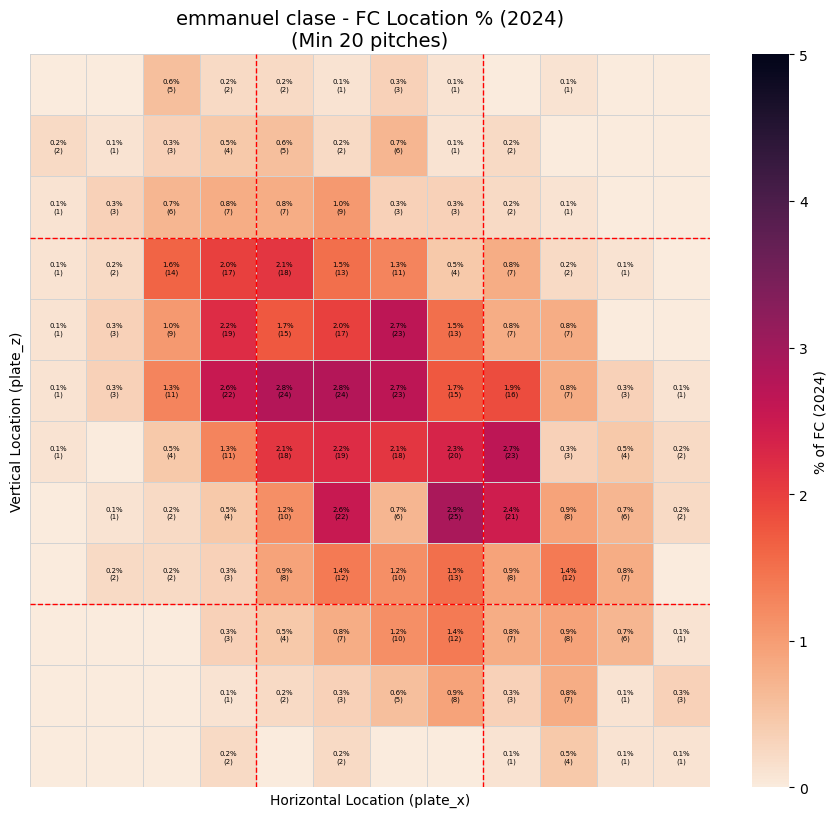

  Generating heatmap for: SL (226 pitches)


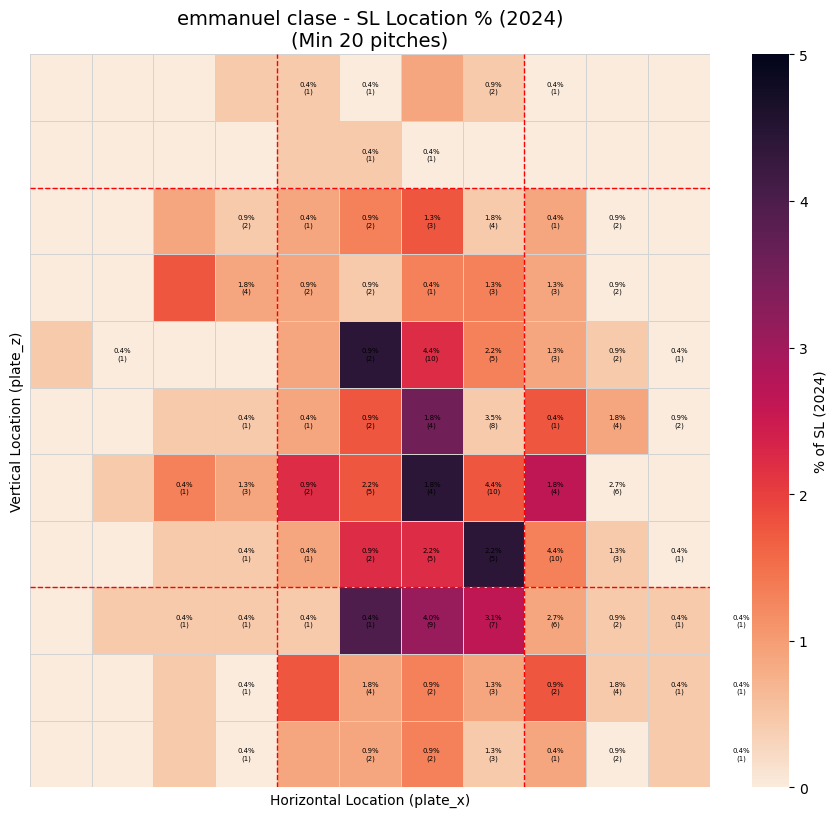


--- Generating Heatmaps for Year: 2025 ---
  Generating heatmap for: FC (218 pitches)


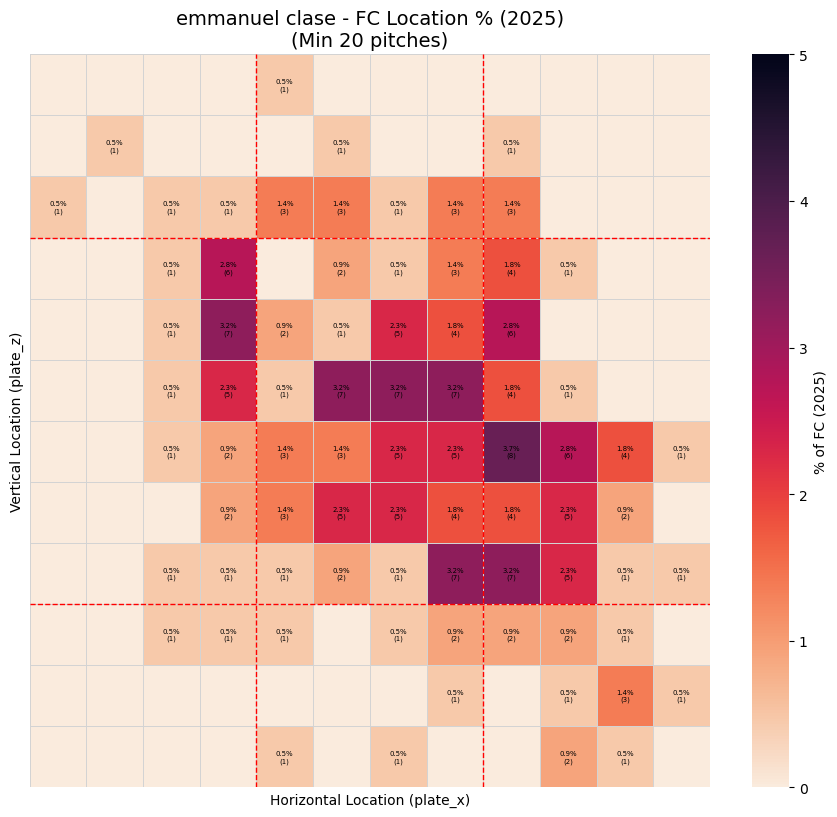

  Generating heatmap for: SL (73 pitches)


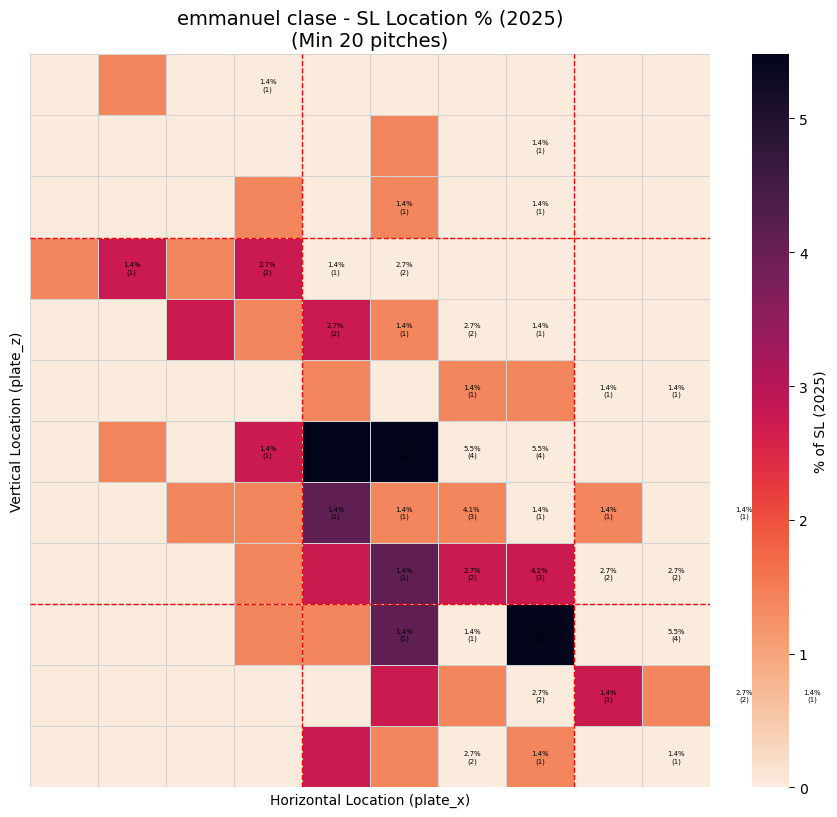

--- End of Block 12 ---


In [37]:
# Block 12: Yearly Pitch Location Percentage Heatmap (12x12 Grid per Pitch/Year)

print("\n--- Block 12: Analyzing Yearly Pitch Location % by Pitch Type (12x12 Grid) ---")

# Check prerequisite data and variables from Block 1
if 'pitcher_statcast_data' in locals() and pitcher_statcast_data is not None and not pitcher_statcast_data.empty and \
   'pitcher_first_name' in locals() and pitcher_first_name and \
   'start_date' in locals() and start_date and \
   'end_date' in locals() and end_date:

    # --- Define Required Columns ---
    required_cols = ['plate_x', 'plate_z', 'pitch_type', 'game_date']

    # Check if all required columns exist
    if all(col in pitcher_statcast_data.columns for col in required_cols):

        # --- Data Preparation & Thresholding ---
        # 1. Filter for pitches with valid location data and pitch type
        location_data = pitcher_statcast_data[
            pitcher_statcast_data['plate_x'].notna() &
            pitcher_statcast_data['plate_z'].notna() &
            pitcher_statcast_data['pitch_type'].notna() &
            pitcher_statcast_data['game_date'].notna()
        ].copy()

        # 2. Extract Year (handle potential errors)
        try:
            location_data['game_date'] = pd.to_datetime(location_data['game_date'], errors='coerce')
            location_data.dropna(subset=['game_date'], inplace=True)
            location_data['year'] = location_data['game_date'].dt.year
        except Exception as e:
            print(f"Error processing game_date: {e}. Cannot proceed.")
            location_data = pd.DataFrame() # Make empty

        if not location_data.empty:
            # 3. Apply Pitch Count Threshold per Year/Pitch Type
            pitch_threshold = 20
            print(f"\nApplying threshold: Keeping year/pitch type combos with >= {pitch_threshold} pitches.")
            location_data['count_per_year_pitch'] = location_data.groupby(['year', 'pitch_type'], observed=True)['pitch_type'].transform('size')
            location_data_filtered = location_data[location_data['count_per_year_pitch'] >= pitch_threshold].copy()

            if not location_data_filtered.empty:
                # Get unique years remaining after threshold
                data_years = sorted(location_data_filtered['year'].unique())
                print(f"Years with pitch types meeting threshold: {data_years}")

                # --- Define Grid and Strike Zone ---
                x_bins_12 = np.linspace(-2.0, 2.0, 13)
                z_bins_12 = np.linspace(0.5, 4.5, 13)
                sz_x_line_1, sz_x_line_2 = 4, 8 # Approx SZ horizontal bin indices
                sz_z_line_1, sz_z_line_2 = 3, 9 # Approx SZ vertical bin indices

                # --- Loop Through Years and Qualifying Pitch Types ---
                for year in data_years:
                    print(f"\n--- Generating Heatmaps for Year: {year} ---")
                    # Get pitch types meeting threshold *for this year*
                    year_data_filtered = location_data_filtered[location_data_filtered['year'] == year]
                    pitches_in_year = sorted(year_data_filtered['pitch_type'].unique())

                    if not pitches_in_year:
                        print(f"  No pitch types met threshold for {year}.")
                        continue

                    for pitch_name in pitches_in_year:
                        # Filter data specifically for this year and pitch type
                        plot_data = year_data_filtered[year_data_filtered['pitch_type'] == pitch_name].copy()
                        total_pitch_type_year_count = len(plot_data) # Already >= threshold

                        print(f"  Generating heatmap for: {pitch_name} ({total_pitch_type_year_count} pitches)")

                        try:
                            # --- Calculate % per Bin for THIS Pitch Type & Year ---
                            plot_data['x_bin'] = pd.cut(plot_data['plate_x'], bins=x_bins_12, labels=False, include_lowest=True) # Use labels=False for easier indexing if needed
                            plot_data['z_bin'] = pd.cut(plot_data['plate_z'], bins=z_bins_12, labels=False, include_lowest=True)
                            plot_data.dropna(subset=['x_bin', 'z_bin'], inplace=True) # Should not drop any if already filtered, but safe

                            if plot_data.empty:
                                print(f"    -> No {pitch_name} pitches in {year} within grid boundaries.")
                                continue

                            # Use crosstab for counts, ensures all bins represented
                            counts_table = pd.crosstab(plot_data['z_bin'], plot_data['x_bin'], dropna=False)
                            percent_table = (counts_table / total_pitch_type_year_count) * 100

                            # Ensure full 12x12 shape if some edge bins were empty
                            # Use the bin edges/intervals for proper indexing if needed, crosstab uses labels (0-11 here)
                            # For simplicity, let's assume crosstab gives indices 0-11. If it errors or looks wrong, need to reindex with IntervalIndex.
                            heatmap_data = percent_table

                            # Create annotation labels
                            annot_labels = pd.DataFrame(index=heatmap_data.index, columns=heatmap_data.columns, dtype=str)
                            for i in heatmap_data.index: # Row index (z_bin label: 0-11)
                                for j in heatmap_data.columns: # Col index (x_bin label: 0-11)
                                    rate = heatmap_data.loc[i, j]
                                    total = counts_table.loc[i, j] # Get count for this bin
                                    if total > 0:
                                        annot_labels.loc[i, j] = f"{rate:.1f}%\n({total:.0f})"
                                    else:
                                        annot_labels.loc[i, j] = "" # Keep empty if count is 0

                            # --- Visualization ---
                            plt.figure(figsize=(9, 9))
                            ax = plt.gca()
                            sns.heatmap(
                                heatmap_data,
                                annot=False, # Annotate manually
                                cmap="rocket_r",
                                linewidths=.5, linecolor='lightgrey',
                                cbar_kws={'label': f'% of {pitch_name} ({year})'},
                                ax=ax, vmin=0, vmax=max(5, heatmap_data.max().max()) # Set vmax dynamically but ensure at least 5%
                            )

                            # Manually add annotations with background
                            bbox_props = dict(boxstyle='round,pad=0.15', fc='white', alpha=0.6, ec='none')
                            for i in heatmap_data.index: # row index 0..11
                                for j in heatmap_data.columns: # col index 0..11
                                    label = annot_labels.loc[i, j]
                                    if label: # Only plot non-empty labels
                                        ax.text(j + 0.5, i + 0.5, label,
                                                ha='center', va='center', color='black', fontsize=5) # Even smaller font

                            # Add Strike Zone lines based on bin indices (0-11)
                            ax.axvline(sz_x_line_1, color='red', linestyle='--', lw=1); ax.axvline(sz_x_line_2, color='red', linestyle='--', lw=1)
                            ax.axhline(sz_z_line_1, color='red', linestyle='--', lw=1); ax.axhline(sz_z_line_2, color='red', linestyle='--', lw=1)

                            ax.invert_yaxis()
                            ax.set_xticks([])
                            ax.set_yticks([])
                            plt.xlabel("Horizontal Location (plate_x)")
                            plt.ylabel("Vertical Location (plate_z)")
                            plt.title(f"{pitcher_first_name} {pitcher_last_name} - {pitch_name} Location % ({year})\n(Min {pitch_threshold} pitches)", fontsize=14)
                            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                            plt.show()

                        except Exception as e:
                             print(f"    -> Could not generate heatmap for {year} - {pitch_name}. Error: {e}")

            else:
                print(f"No pitch types met the {pitch_threshold} pitch minimum threshold within any year.")
                print(f"Original pitch count before threshold: {len(location_data)}")
        else:
             print("No valid location data found to analyze.")

    else:
        # Required columns missing
        missing = [col for col in required_cols if col not in pitcher_statcast_data.columns]
        print(f"Skipping yearly location heatmap analysis because required columns are missing: {', '.join(missing)}")

elif pitcher_statcast_data is None:
    print("Skipping yearly location heatmap analysis because pitcher data was not loaded successfully in Block 1.")
else:
     print("Skipping yearly location heatmap analysis because the dataset was empty or pitcher/date info is missing.")

print("--- End of Block 12 ---")